In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from datetime import datetime


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/toi-260/'
stispath = '{}stis/'.format(path)
cospath = '{}cos/'.format(path)

In [4]:
x1ds = np.hstack((glob.glob('{}*0_x1d.fits'.format(stispath)), glob.glob('{}*sx1.fits'.format(stispath))))#, glob.glob('{}*x1dsum.fits'.format(path))))
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/toi-260/stis/oeoo10010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-260/stis/oeoo10020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-260/stis/oeoo10030_sx1.fits'],
      dtype='<U72')

/media/david/2tb_ext_hd/hddata/meats/hst/toi-260/stis/oeoo10010_x1d.fits
G140M
[716.3372]


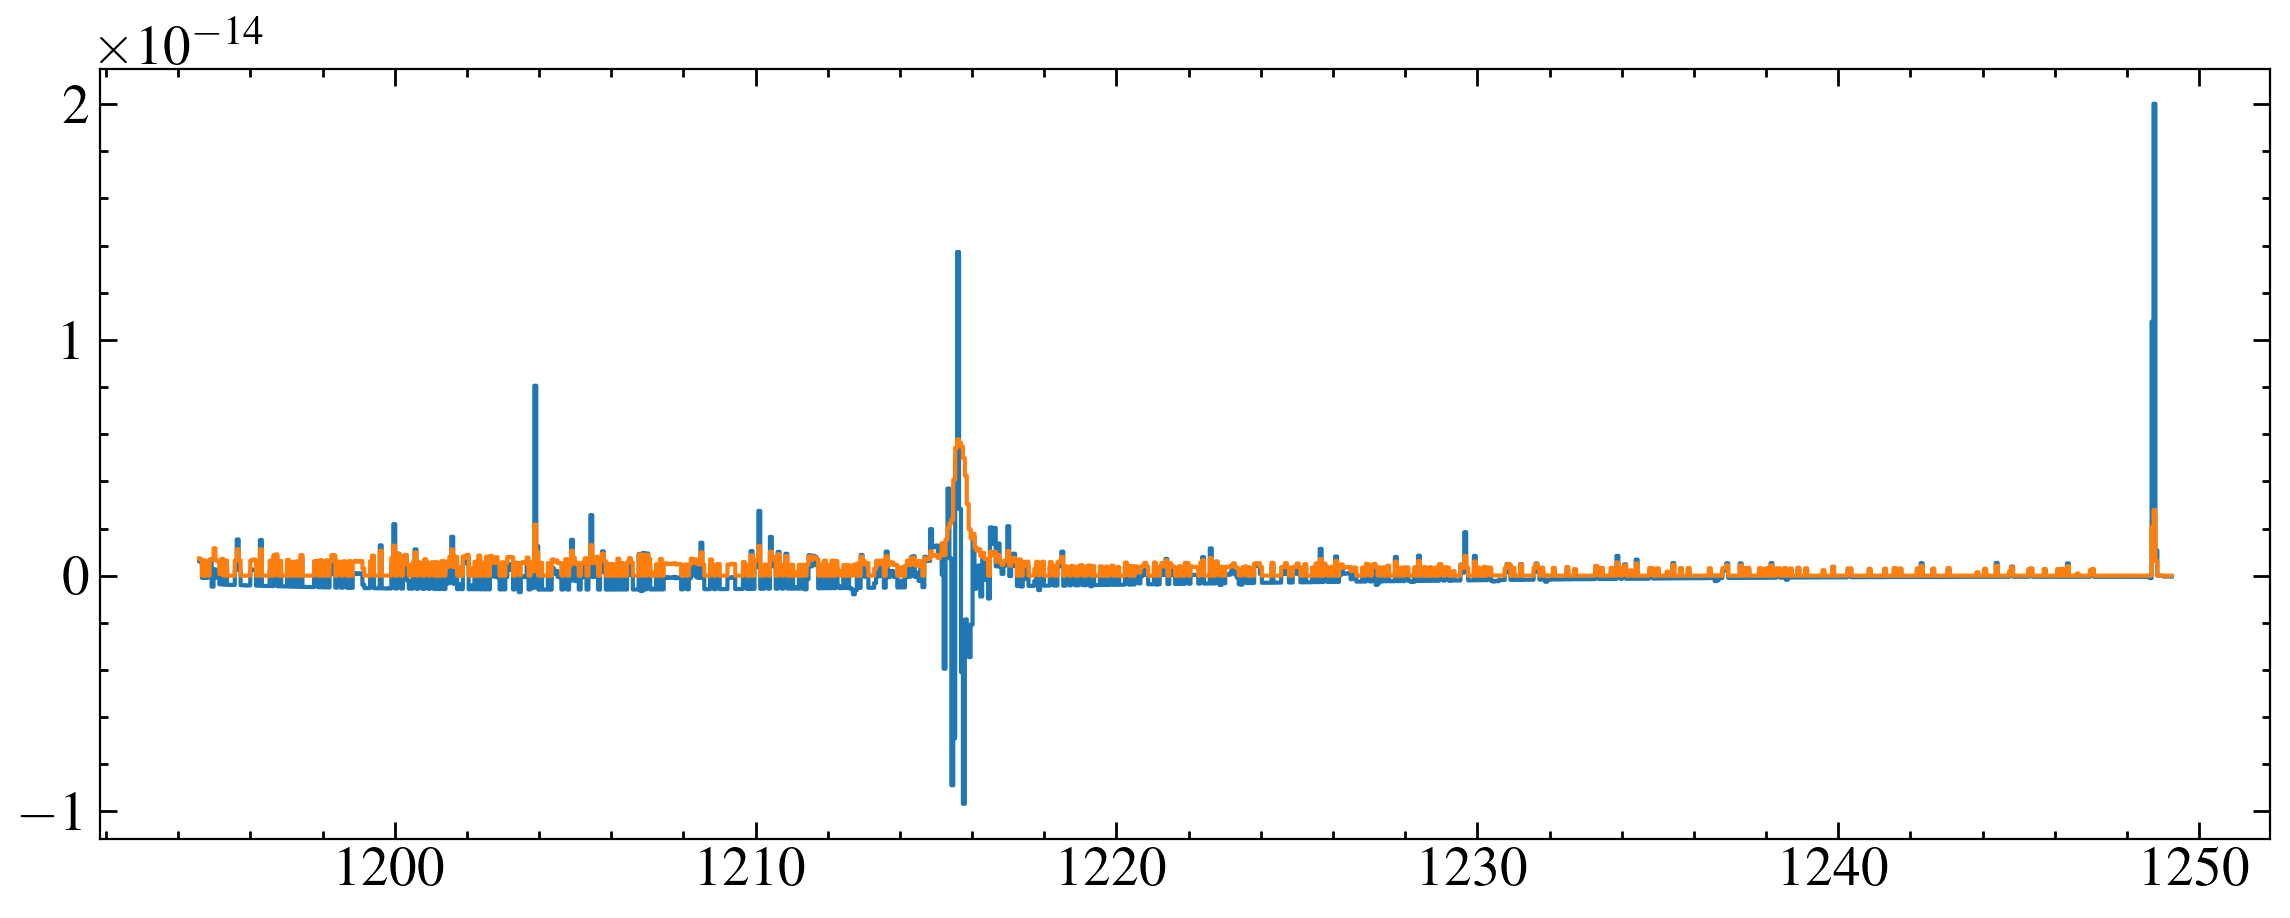

/media/david/2tb_ext_hd/hddata/meats/hst/toi-260/stis/oeoo10020_x1d.fits
G230L
[511.0998]


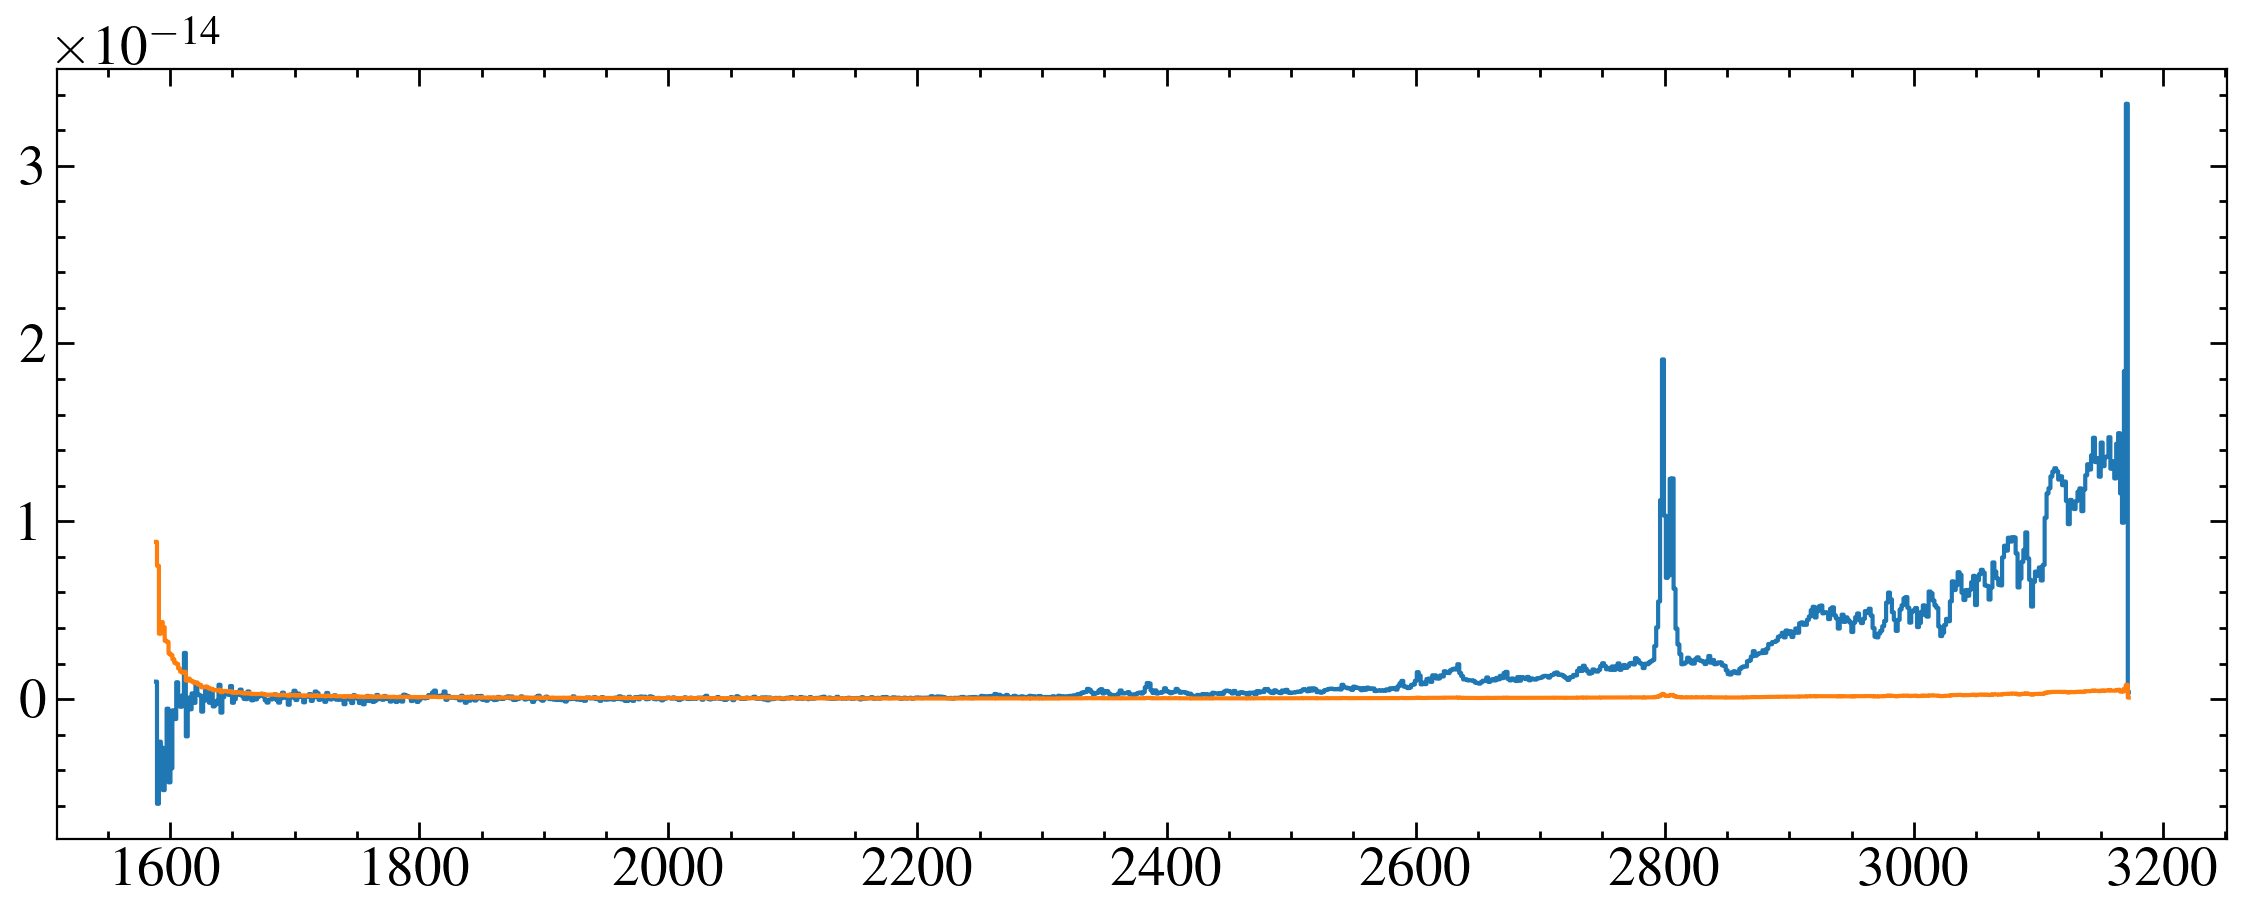

/media/david/2tb_ext_hd/hddata/meats/hst/toi-260/stis/oeoo10030_sx1.fits
G430L
[895.1814]


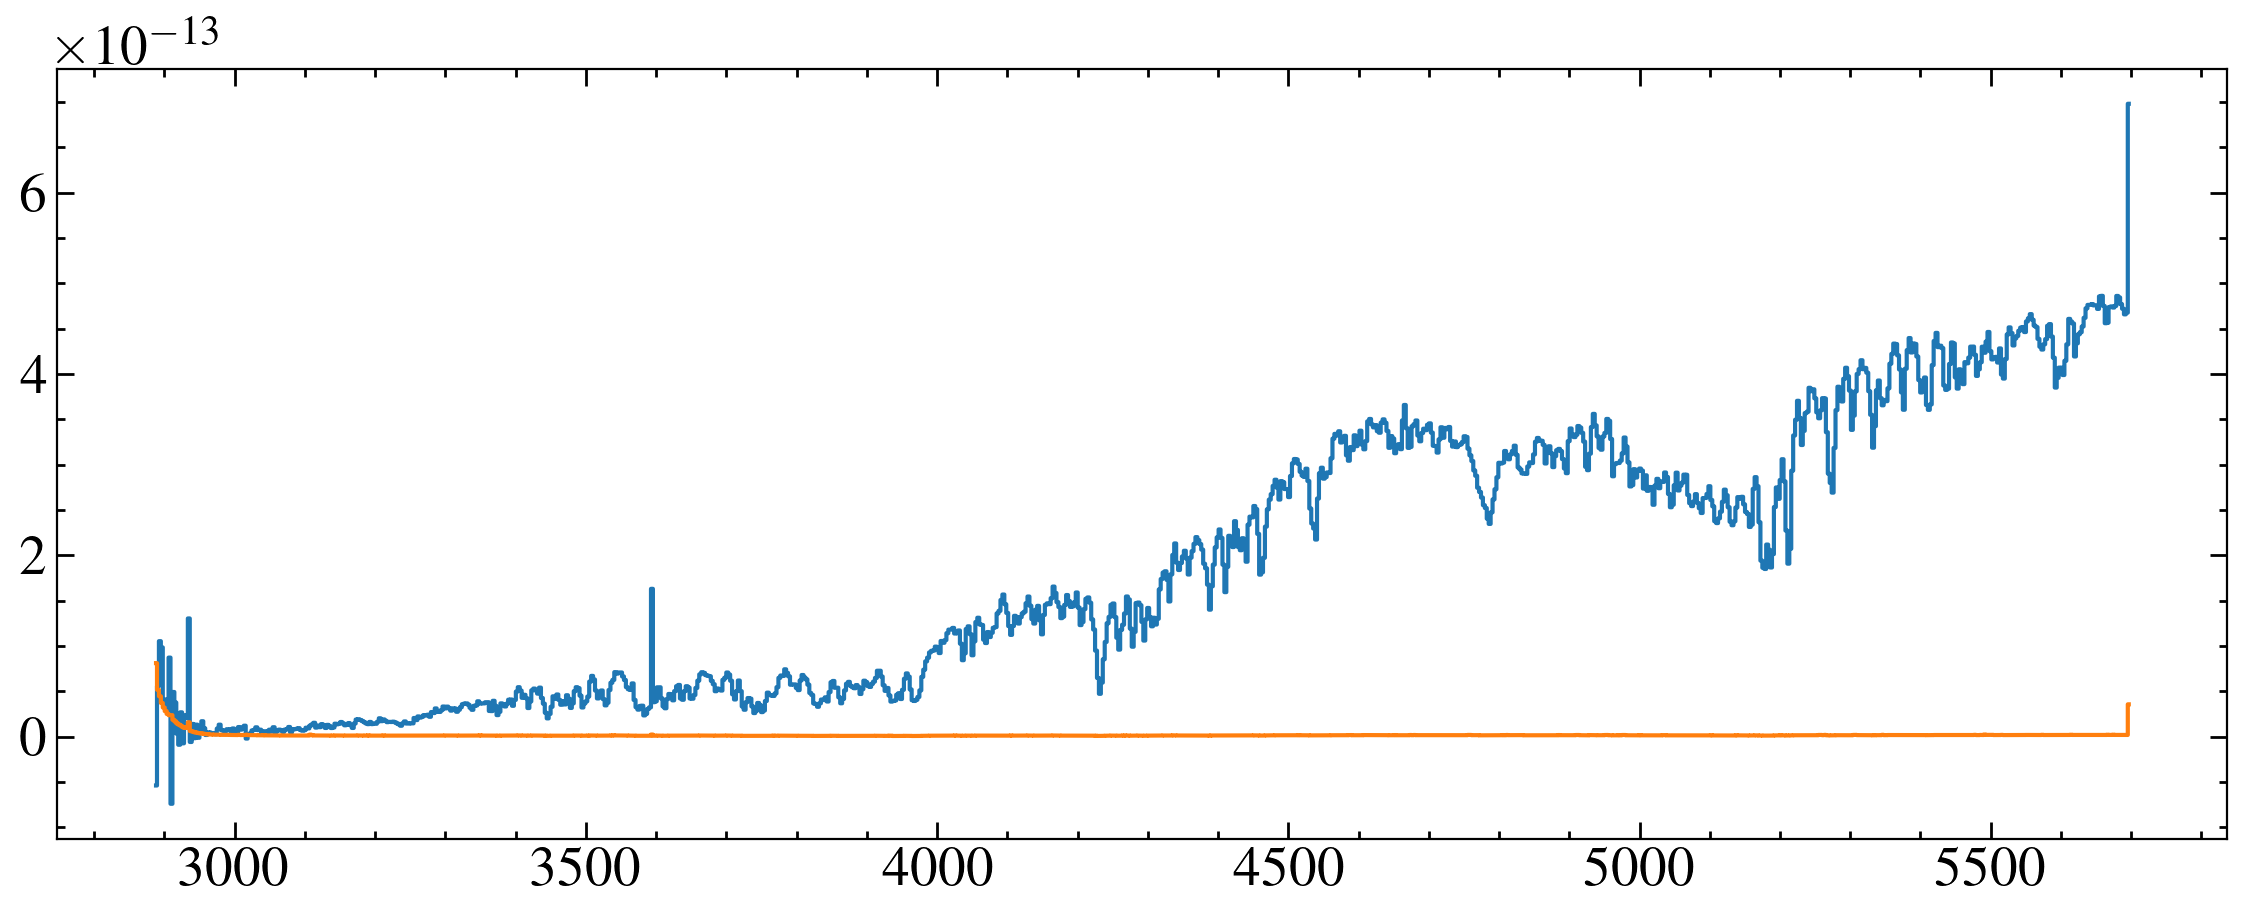

In [5]:
for x in x1ds:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1160
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid', c='C0')
    plt.step(w, e, where='mid', c='C1')
    plt.show()


Need to reextract G140M but it's clearly visible in the flt. COS first though

In [6]:
x1dpath = '/media/david/2tb_ext_hd/hddata/meats/hst/toi-260/cos/leoo11010_x1dsum.fits'
xdata = fits.getdata(x1dpath, 1)

cdata = Table.read('cos_files/toi-260/TOI260_COS130M_Mm1_NOSCL_07aug2024.sav.txt', format='ascii.basic')

['/media/david/2tb_ext_hd/hddata/meats/hst/toi-260/cos/leoo11010_x1dsum.fits']
['/media/david/2tb_ext_hd/hddata/meats/hst/toi-260/cos/leoo11010_x1dsum.fits']


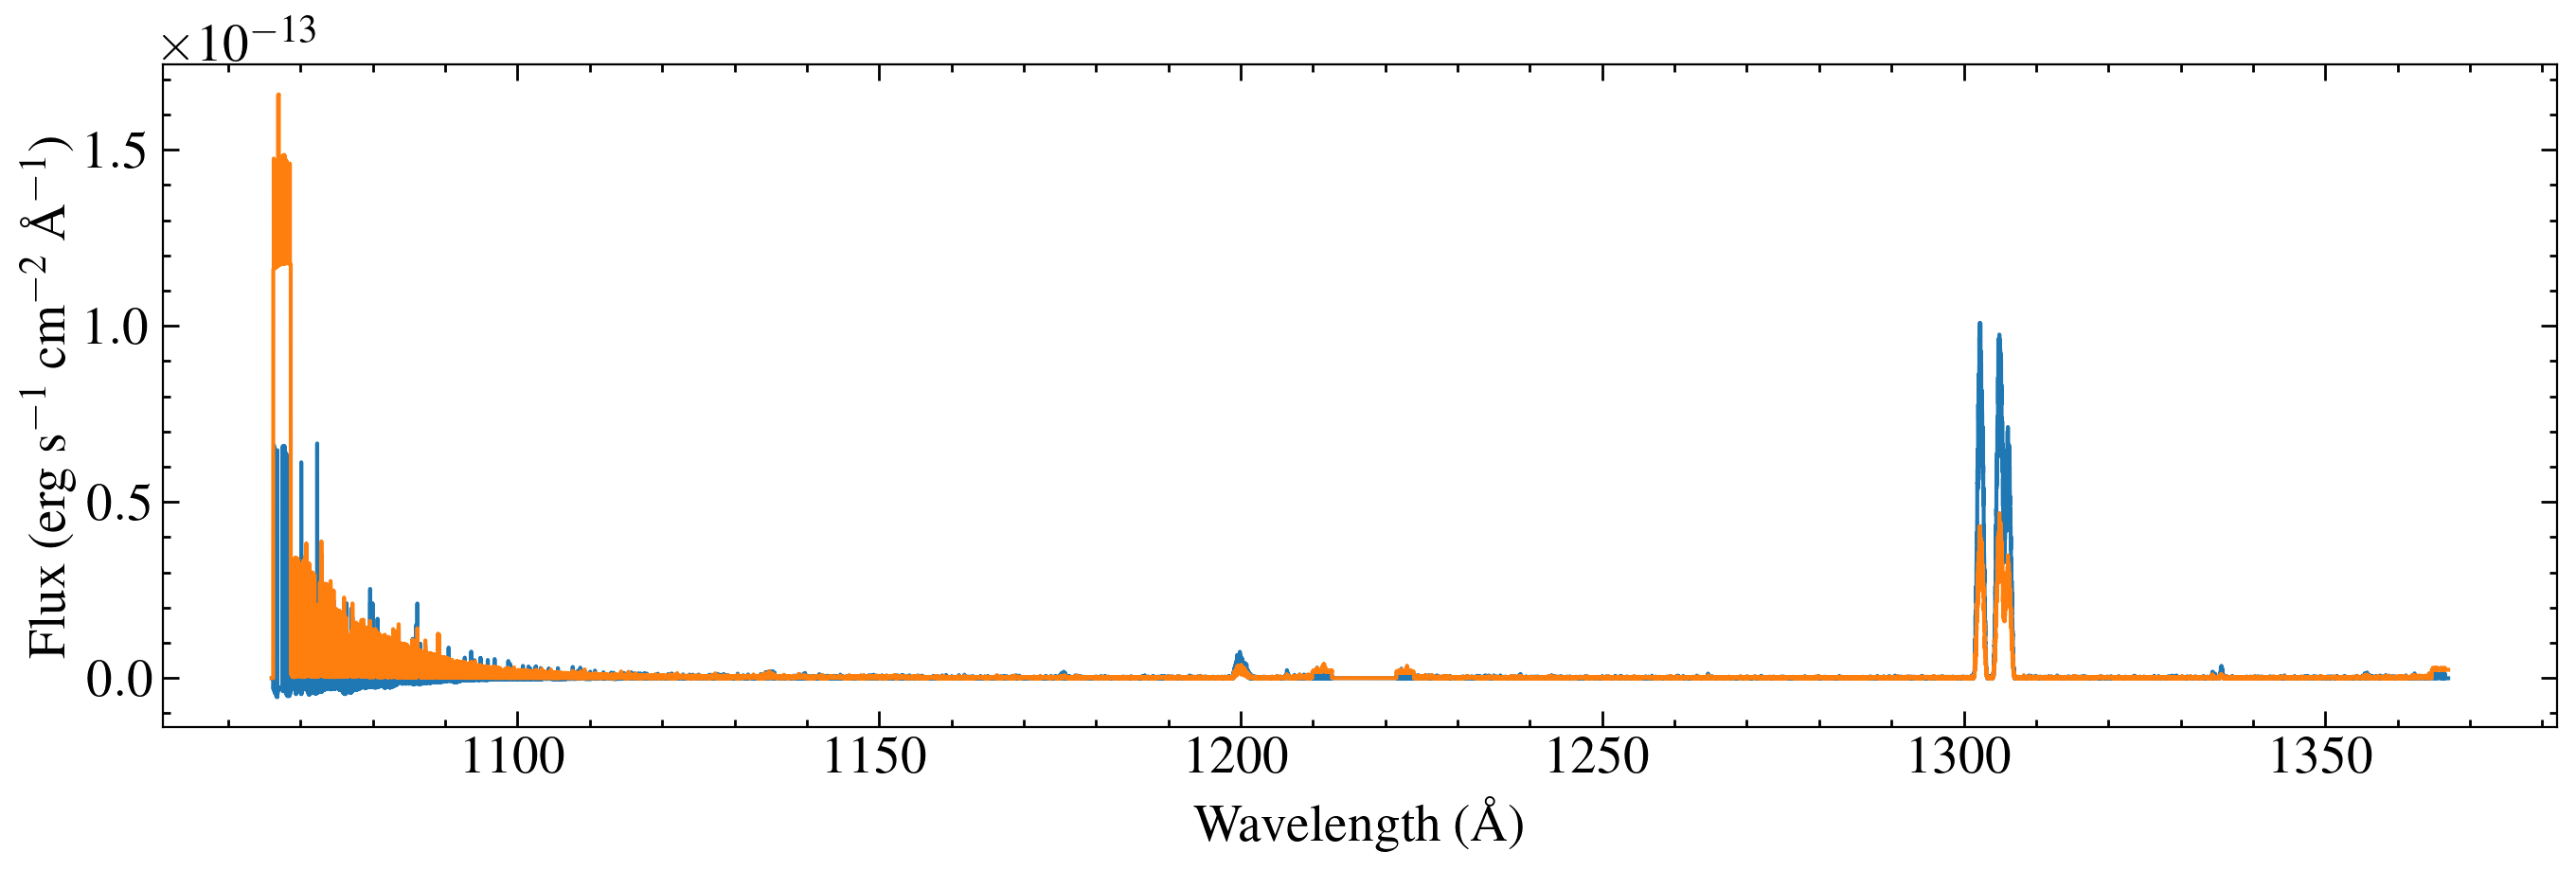

Spectrum saved as hlsp_muscles_hst_cos_toi-260_g130m_v1_component-spec.fits


In [7]:
import prepare_cos
# importlib.reload(prepare_cos)

savpath = 'cos_files/toi-260/TOI260_COS130M_Mm1_NOSCL_07aug2024.sav.txt'
x1dpath = '/media/david/2tb_ext_hd/hddata/meats/hst/toi-260/cos/'
hlsp = 'meats_hlsp_info.csv'
version = 1
savepath = 'draft_hlsp/toi-260/'
# star = 
prepare_cos.make_cos_spectrum(savpath, version, x1dpath, hlsp, savepath = savepath, plot=True, save_fits=True, star='TOI-260')

Where did the lya spectrum come from?

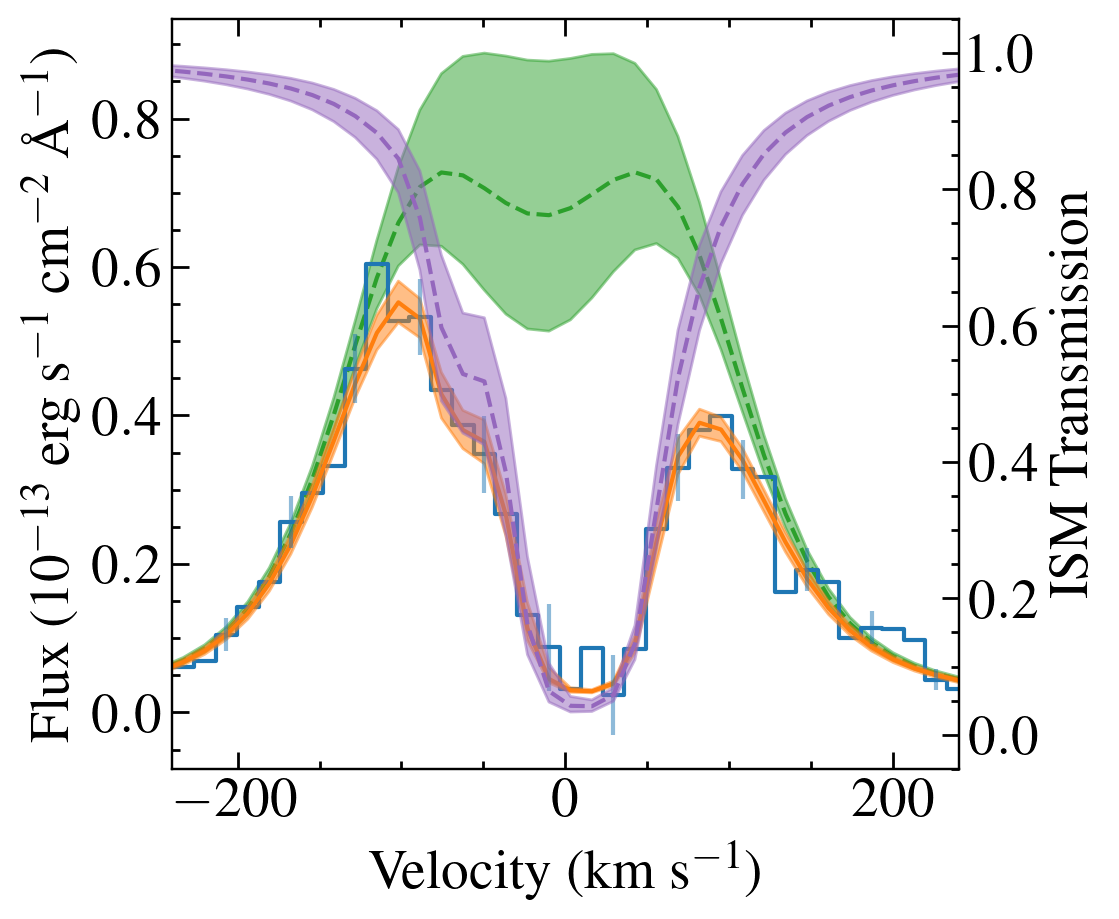

In [8]:
lyapath = '/media/david/2tb_ext_hd/hddata/meats/lya/toi-260/TOI260_LyA_MCMC_results.csv'
data = Table.read(lyapath)
# data.dtype.names


lya = 1215.67
ism_scale = 2.3e-13 #scaling ism to plot
fscale = 1e13 #scaling flux to axis
ism_scale *= fscale

fig, ax= plt.subplots(figsize=(6,5))
v = (data['wave_lya']*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
ax.step(v, data['flux_lya']*fscale, c='C0', label = 'Observed Spectrum', zorder=0, where='mid')
ax.errorbar(v, data['flux_lya']*fscale, yerr=data['error_lya']*fscale, alpha=0.5, errorevery=3, ls='none', c='C0')
ax.plot(v, data['lya_model_median']*fscale, c='C1', label='Model fit', zorder=1)
ax.fill_between(v.value, data['lya_model_high_1sig']*fscale,data['lya_model_low_1sig']*fscale, color='C1', alpha=0.5)

ax.plot(v, data['lya_intrinsic_median']*fscale, c='C2', ls='--', label=r'Intrinsic Ly$\alpha$ profile', zorder=-1)
ax.fill_between(v.value, data['lya_intrinsic_high_1sig']*fscale,data['lya_intrinsic_low_1sig']*fscale, color='C2', alpha=0.5, zorder=-10)

# name = os.path.split(spec)[1][:-34]
# ax.set_title(name, size=20)

# xlim = min([abs(min(v.value)), max(v.value)])-10
xlim = 240
ax.set_xlim(-xlim, xlim)
ax2=ax.twinx()
ax2.plot(v, data['lya_ism_median'], c='C4', ls='--', alpha=1, label='ISM profile', zorder=-9)
ax2.fill_between(v.value, data['lya_ism_high_1sig'],data['lya_ism_low_1sig'], color='C4', alpha=0.5, zorder=-10)
ax2.set_ylim(-0.05, 1.05)
ax2.set_ylabel('ISM Transmission')


ax.set_xlabel('Velocity (km s$^{-1}$)', size=20)
ax.set_ylabel('Flux (10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)

fig.tight_layout()

# fig.savefig('plots/toi-776_lya.pdf')

In [9]:
lw, lf, le = data['wave_lya'], data['lya_intrinsic_median'], np.mean([data['lya_intrinsic_high_1sig']-data['lya_intrinsic_median'], data['lya_intrinsic_median']-data['lya_intrinsic_low_1sig']], axis=0)
lyatab = Table([lw, lf, le], names=['WAVELENGTH', 'FLUX', 'ERROR'])
lyatab.write('models/toi-260_lya.ecsv', overwrite=True)

In [10]:
import stistools
os.environ['oref'] = stispath 

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


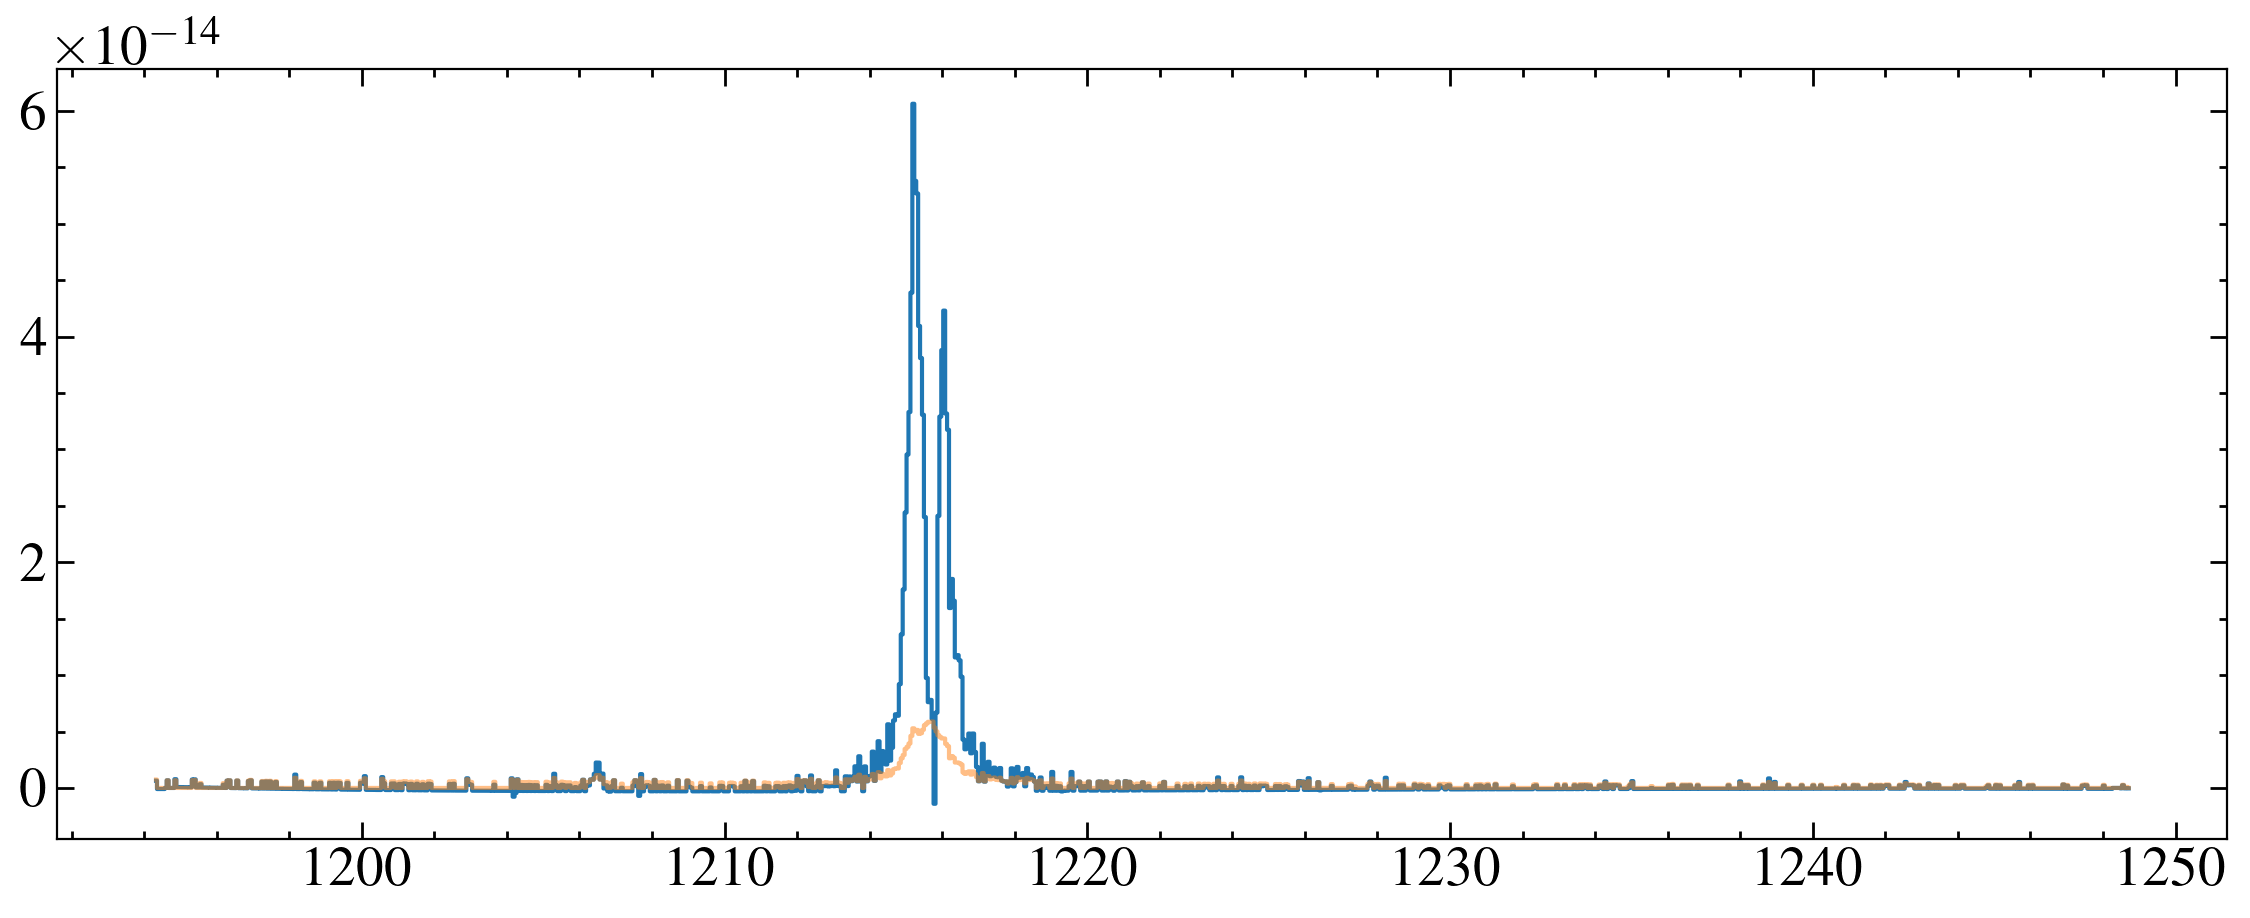

In [31]:
roots = ['oeoo10010']


for i, root in  enumerate(roots):
    flt = '{}/{}_flt.fits'.format(stispath, root)
    # SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
    # grating = fits.getheader(flt,0)['OPT_ELEM']
    # cenwave = fits.getheader(flt,0)['CENWAVE']
    # tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
    rootname = fits.getheader(flt)['ROOTNAME'] 
    outname = 'reextractions/toi-260/{}_new_x1d.fits'.format(rootname)
    if os.path.exists(outname):
        os.remove(outname)
    # a2center = get_a2center(xs[i], ys[i], tracegrid)
    a2center = 192
    # print(a2center)
    stistools.x1d.x1d(flt, output = outname, trailer='reextractions/toi-260/{}_new.trl'.format(rootname), a2center=a2center, maxsrch=10)

    fig, ax = plt.subplots()
    data = fits.getdata(outname, 1)[0]
    ax.step(data['WAVELENGTH'], data['FLUX'], where='mid')
    ax.step(data['WAVELENGTH'], data['ERROR'], where='mid', alpha=0.5)
    plt.show()
    


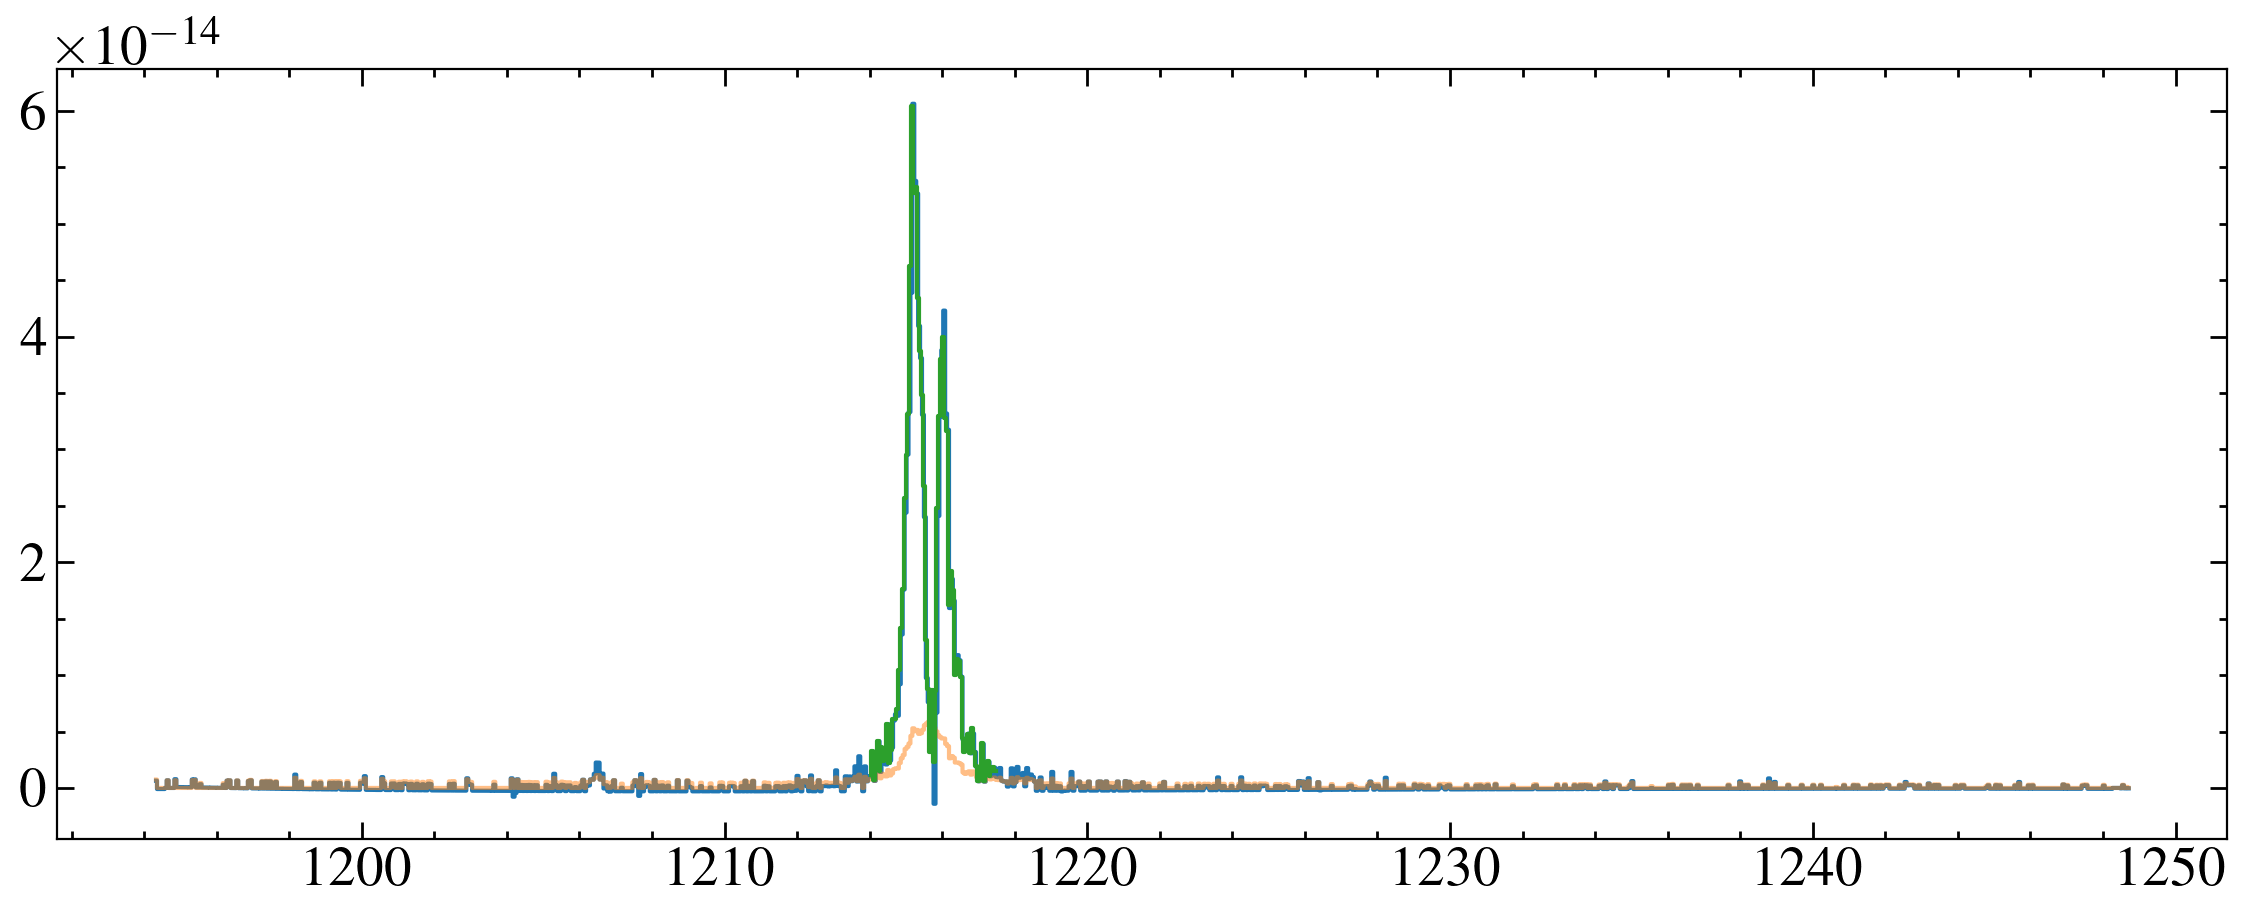

In [32]:
fig, ax = plt.subplots()
data = fits.getdata(outname, 1)[0]
ax.step(data['WAVELENGTH'], data['FLUX'], where='mid')
ax.step(data['WAVELENGTH'], data['ERROR'], where='mid', alpha=0.5)

# ax.step(lw, lf)

lyapath = '/media/david/2tb_ext_hd/hddata/meats/lya/toi-260/TOI260_LyA_MCMC_results.csv'
data = Table.read(lyapath)
ax.step(lw, data['flux_lya'])

Well that is a different spectrum. Do the rest of it while I wait. No I was wrong, right spectrum

In [33]:
prepare_model.make_model_spectrum('models/toi-260_lya.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1, model_name='lya')


Spectrum saved as hlsp_muscles_model_lya_toi-260_na_v1_component-spec.fits


/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/astropy/stats/funcs.py:745: RuntimeWarning: invalid value encountered in sqrt
  [n + 0.5 - np.sqrt(n + 0.25), n + 0.5 + np.sqrt(n + 0.25)]


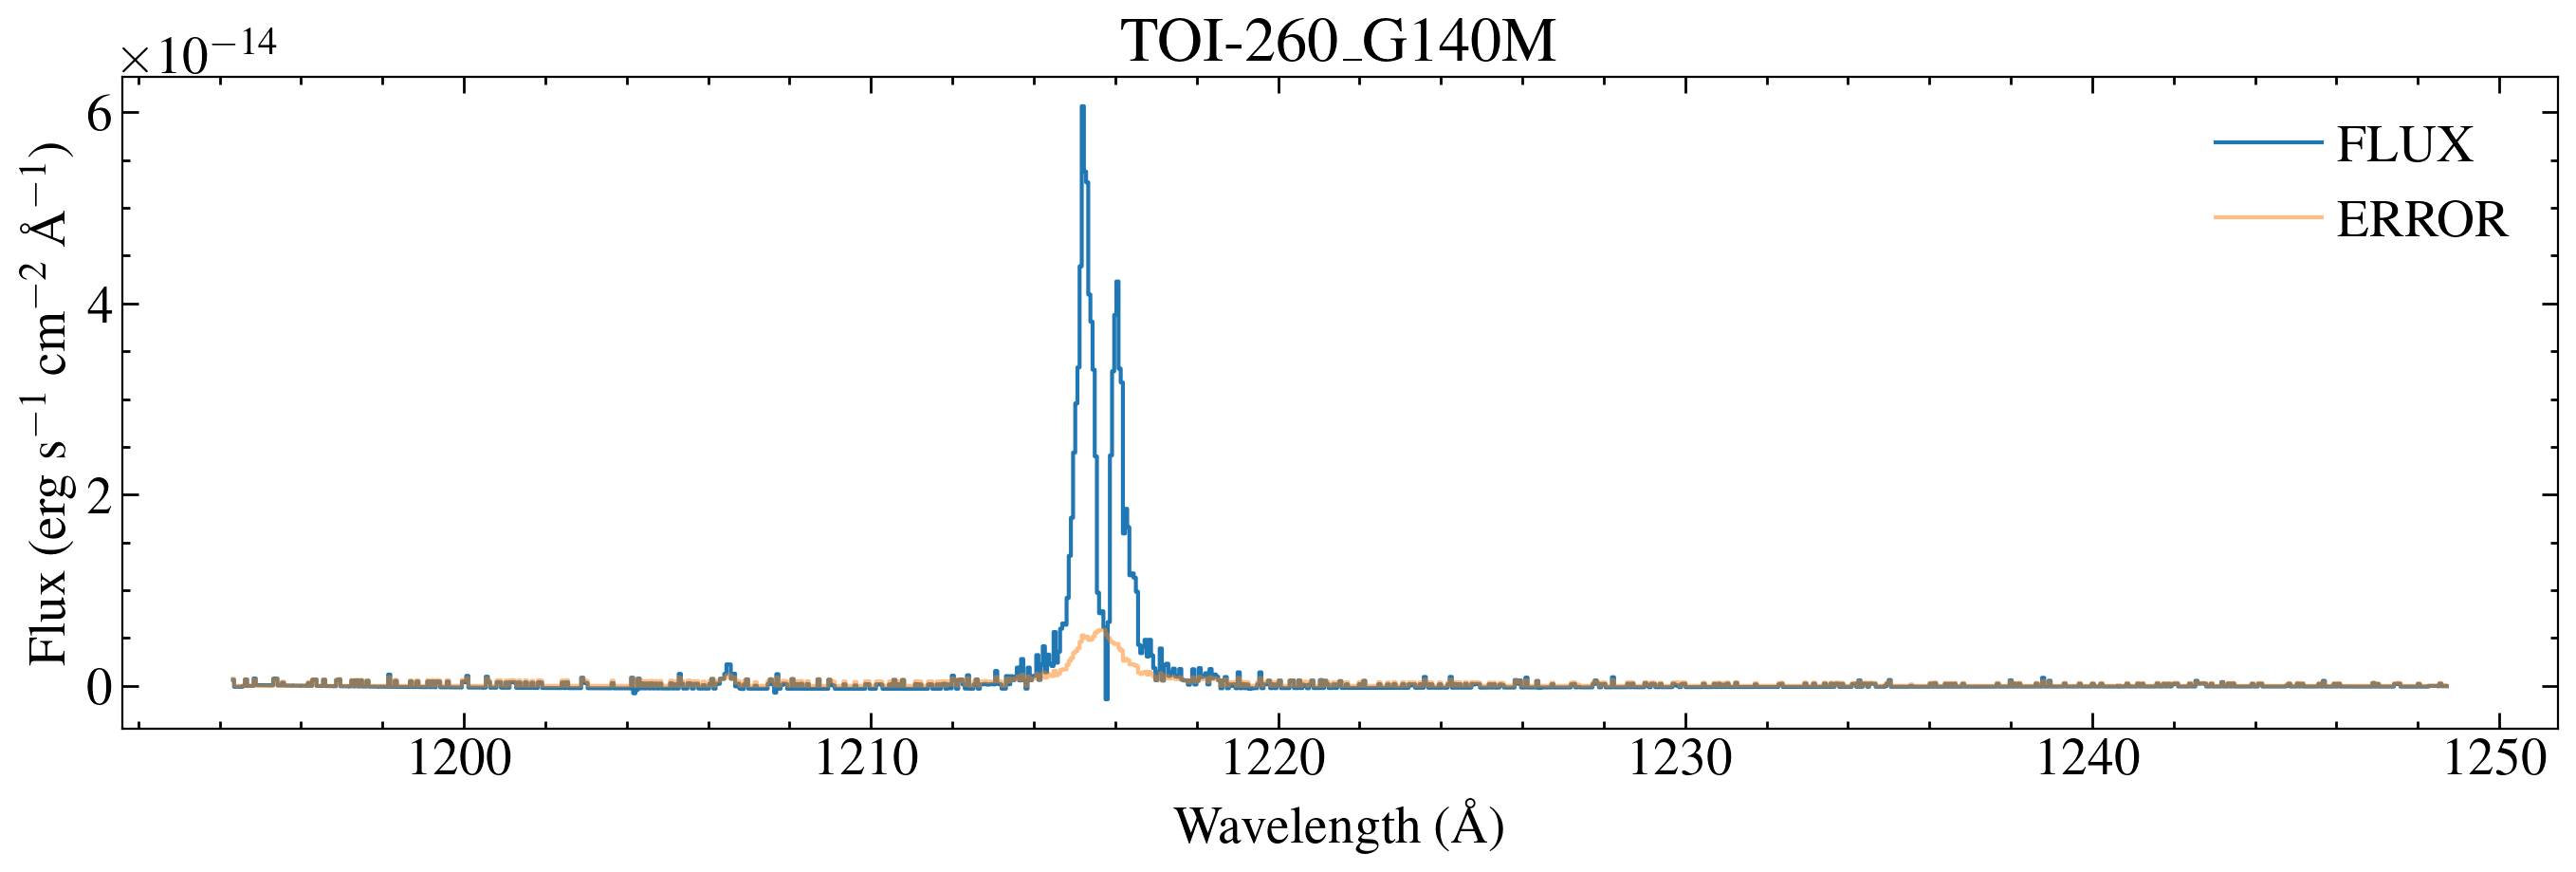

Spectrum saved as hlsp_muscles_hst_stis_toi-260_g140m_v1_component-spec.fits


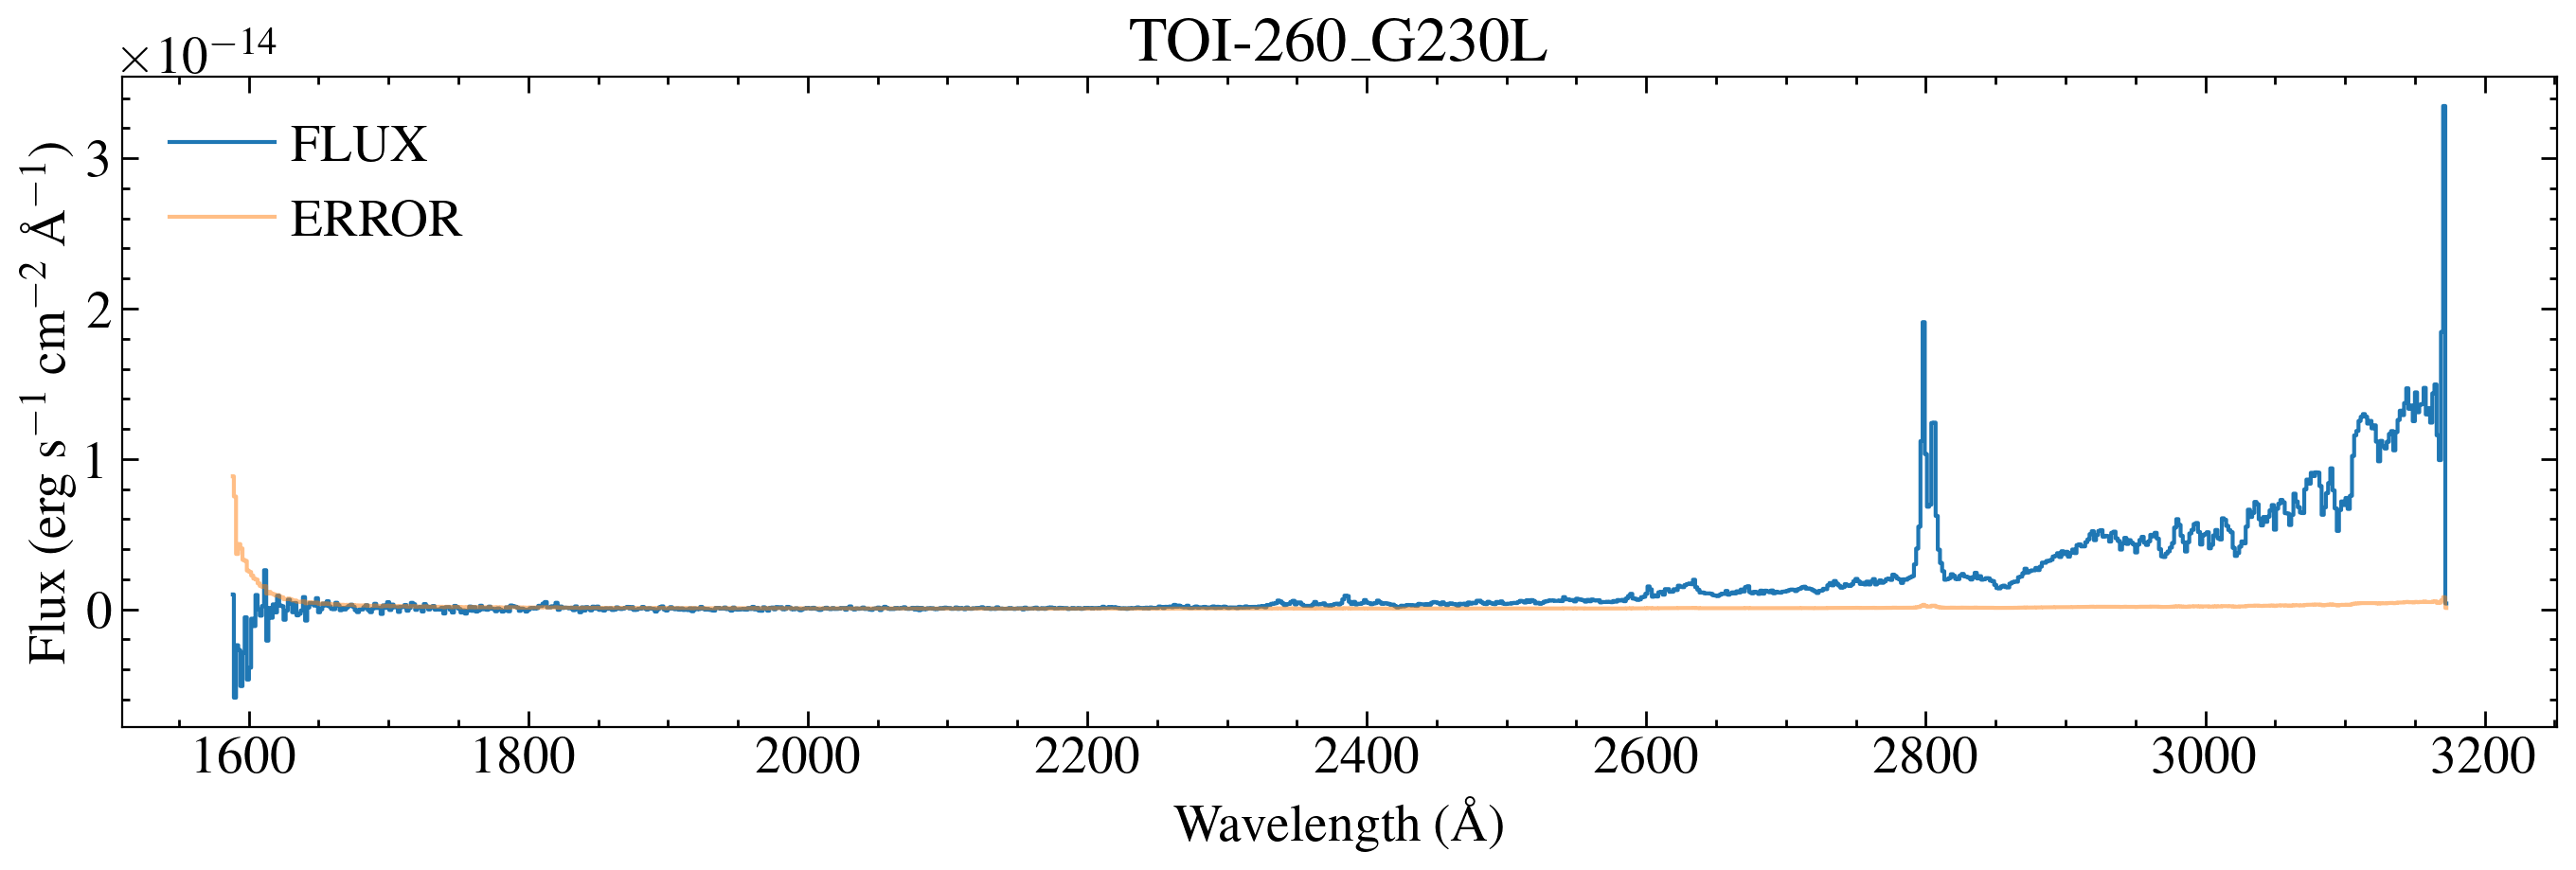

Spectrum saved as hlsp_muscles_hst_stis_toi-260_g230l_v1_component-spec.fits


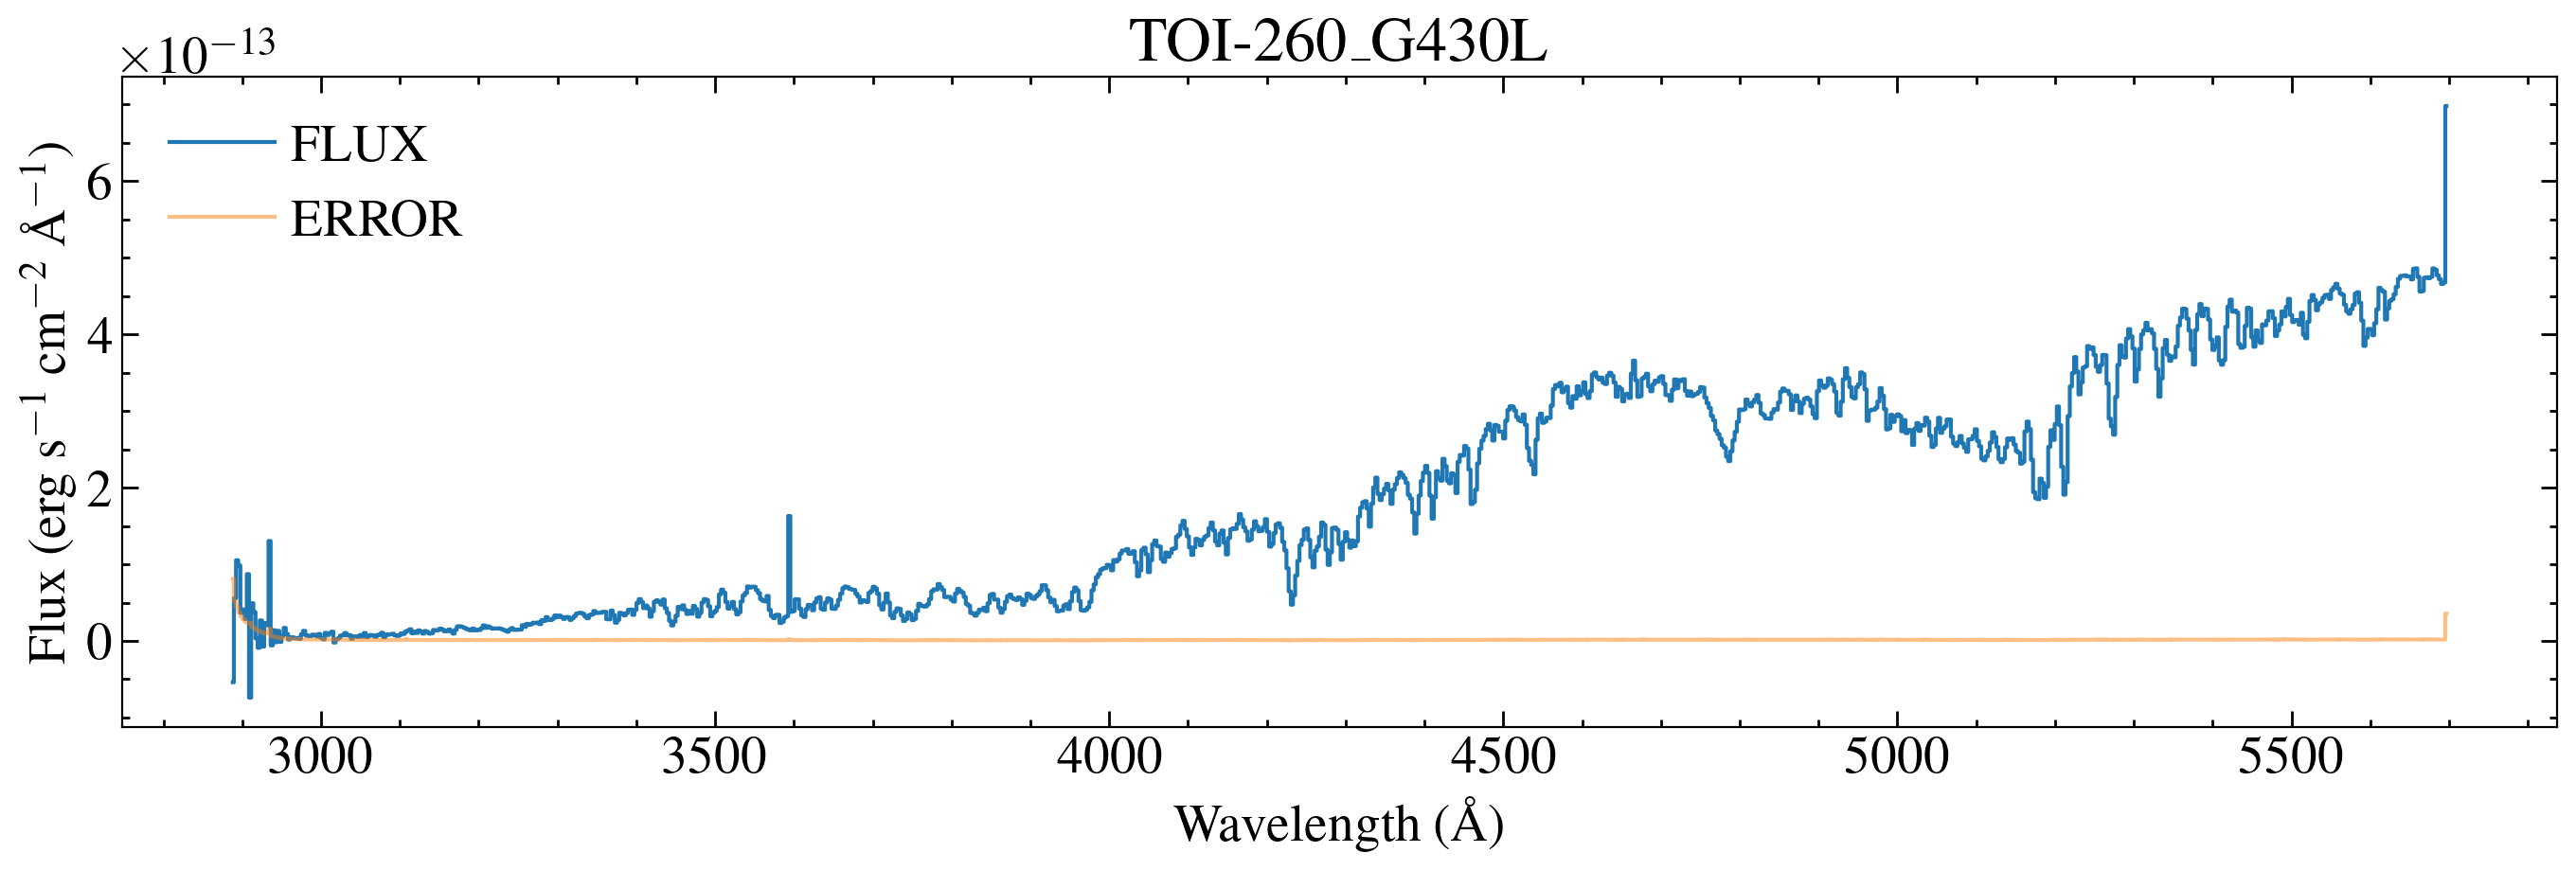

Spectrum saved as hlsp_muscles_hst_stis_toi-260_g430l_v1_component-spec.fits


In [13]:
import prepare_stis
x1dpath = '/media/david/2tb_ext_hd/hddata/meats/hst/toi-260/stis/use_spectra/'
savepath = 'draft_hlsp/toi-260/'
hlsp = 'meats_hlsp_info.csv'
version = 1
prepare_stis.make_stis_spectrum(x1dpath, version, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = 'TOI-260')

In [14]:
#changing params to those from Hobson+24


import prepare_phoenix_svo as pp
# importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.616
teff = 4026
teff_e = 14

radius = 0.607
distance = 20.1852

save_path = 'models/'
star = 'toi-260'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
g = 4.45
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
pdata = Table.read('models/{}_phoenix_interpolated.ecsv'.format(star))
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

In [15]:
hlsp_stis = glob.glob('draft_hlsp/toi-260/*stis*.fits')
hlsp_stis

['draft_hlsp/toi-260/hlsp_muscles_hst_stis_toi-260_g140m_v1_component-spec.fits',
 'draft_hlsp/toi-260/hlsp_muscles_hst_stis_toi-260_g430l_v1_component-spec.fits',
 'draft_hlsp/toi-260/hlsp_muscles_hst_stis_toi-260_g230l_v1_component-spec.fits']

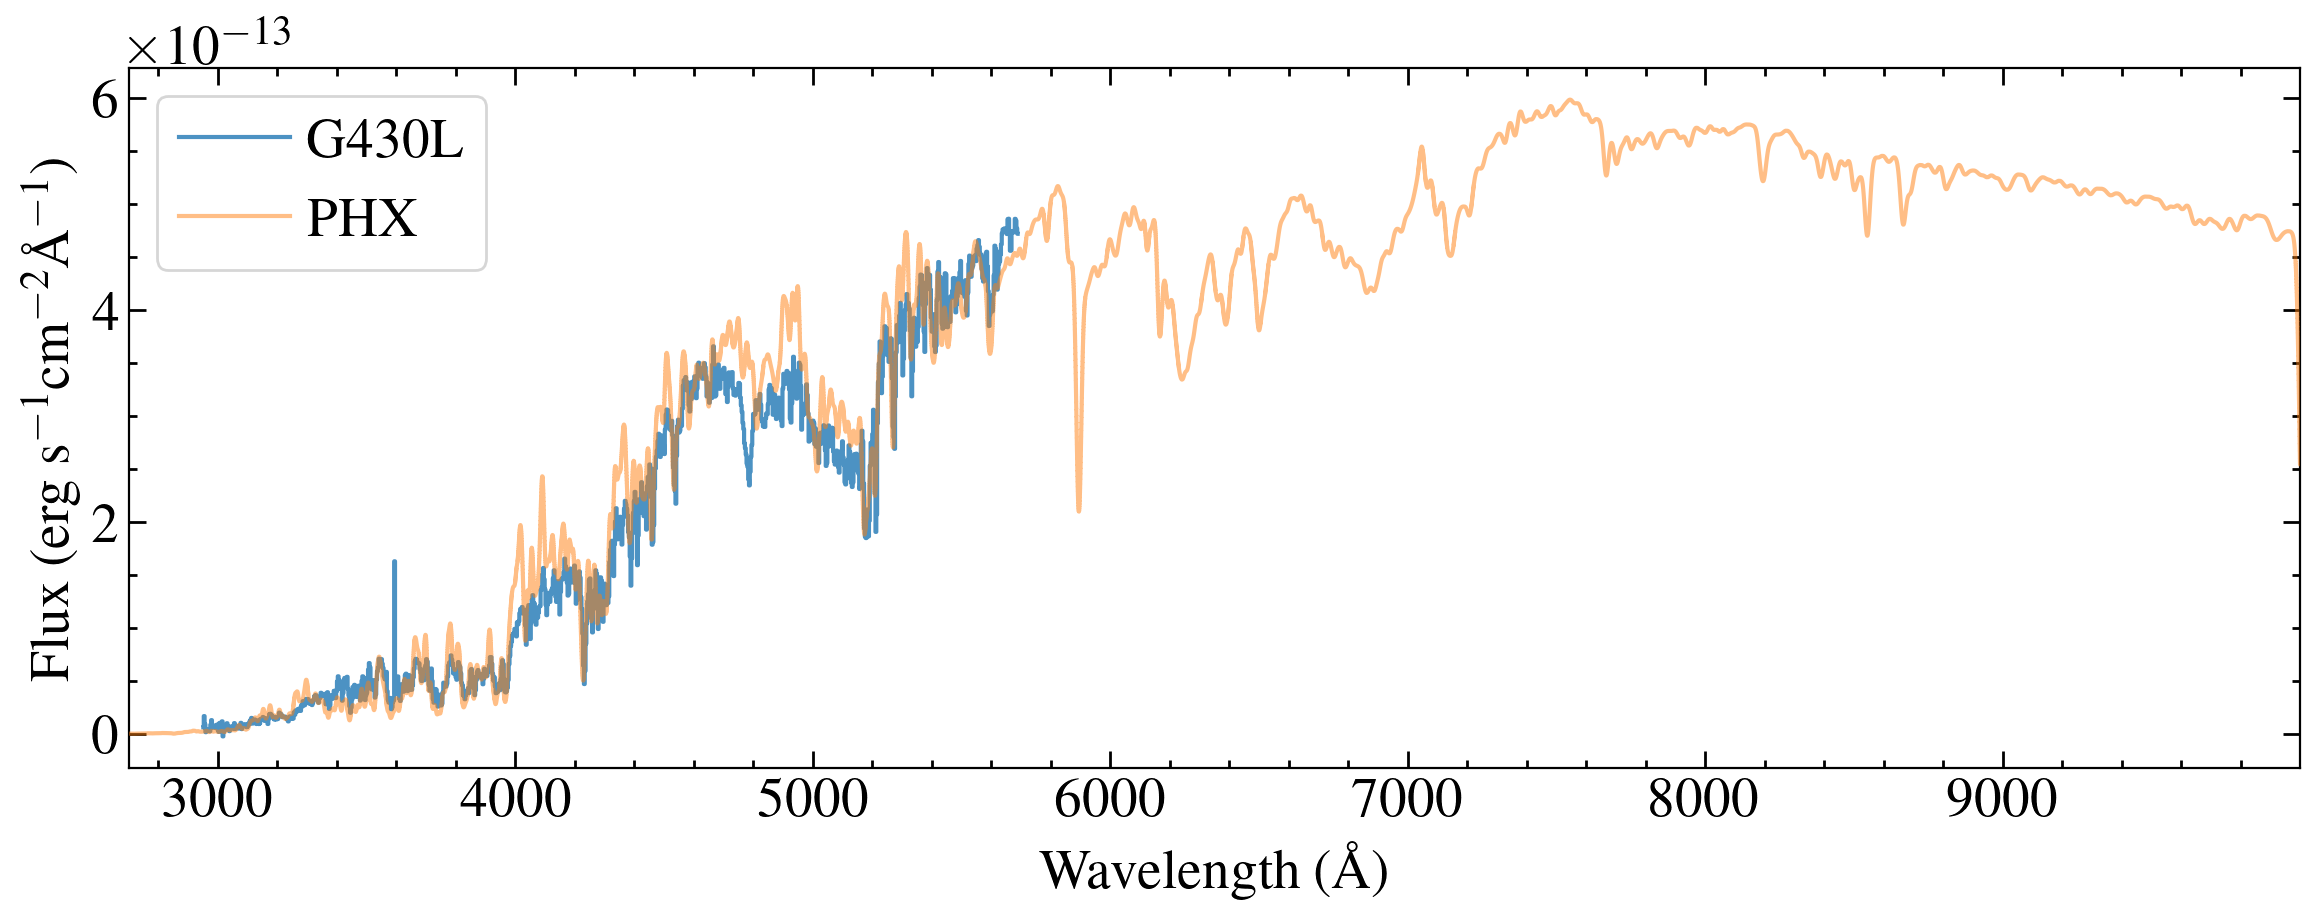

In [16]:
pmask = (pw > 2500) & (pw < 10000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi, 1000)


fig, ax = plt.subplots(figsize=(12,5))



# for spec in hlsp_stis:
spec = hlsp_stis[1]
data = fits.getdata(spec, 1)
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

mask = (w > 2950) & (w < 5690 )    
w, f, e = w[mask], f[mask], e[mask]


ax.step(w, f, where='mid', label = 'G430L',  alpha=0.8)
  
ax.step(pwi, pfi, where='mid', zorder=10, alpha=0.5, label = 'PHX')

ax.legend(frameon=True)

ax.set_ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
ax.set_xlabel('Wavelength (\AA)')



ax.set_xlim(2701, 9999)

fig.tight_layout()




Much better. 

In [17]:
import prepare_model
hdr = fits.getheader('draft_hlsp/toi-260/hlsp_muscles_hst_stis_toi-260_g140m_v1_component-spec.fits', 0)
sed_data = Table(meta=hdr)

In [18]:
prepare_model.make_model_spectrum('models/toi-260_phoenix_interpolated.ecsv', 1, sed_data,
                                  savepath = savepath, save_ecsv=False, save_fits=True, normfac=normfac.value, model_name='PHX')

Spectrum saved as hlsp_muscles_model_phx_toi-260_na_v1_component-spec.fits


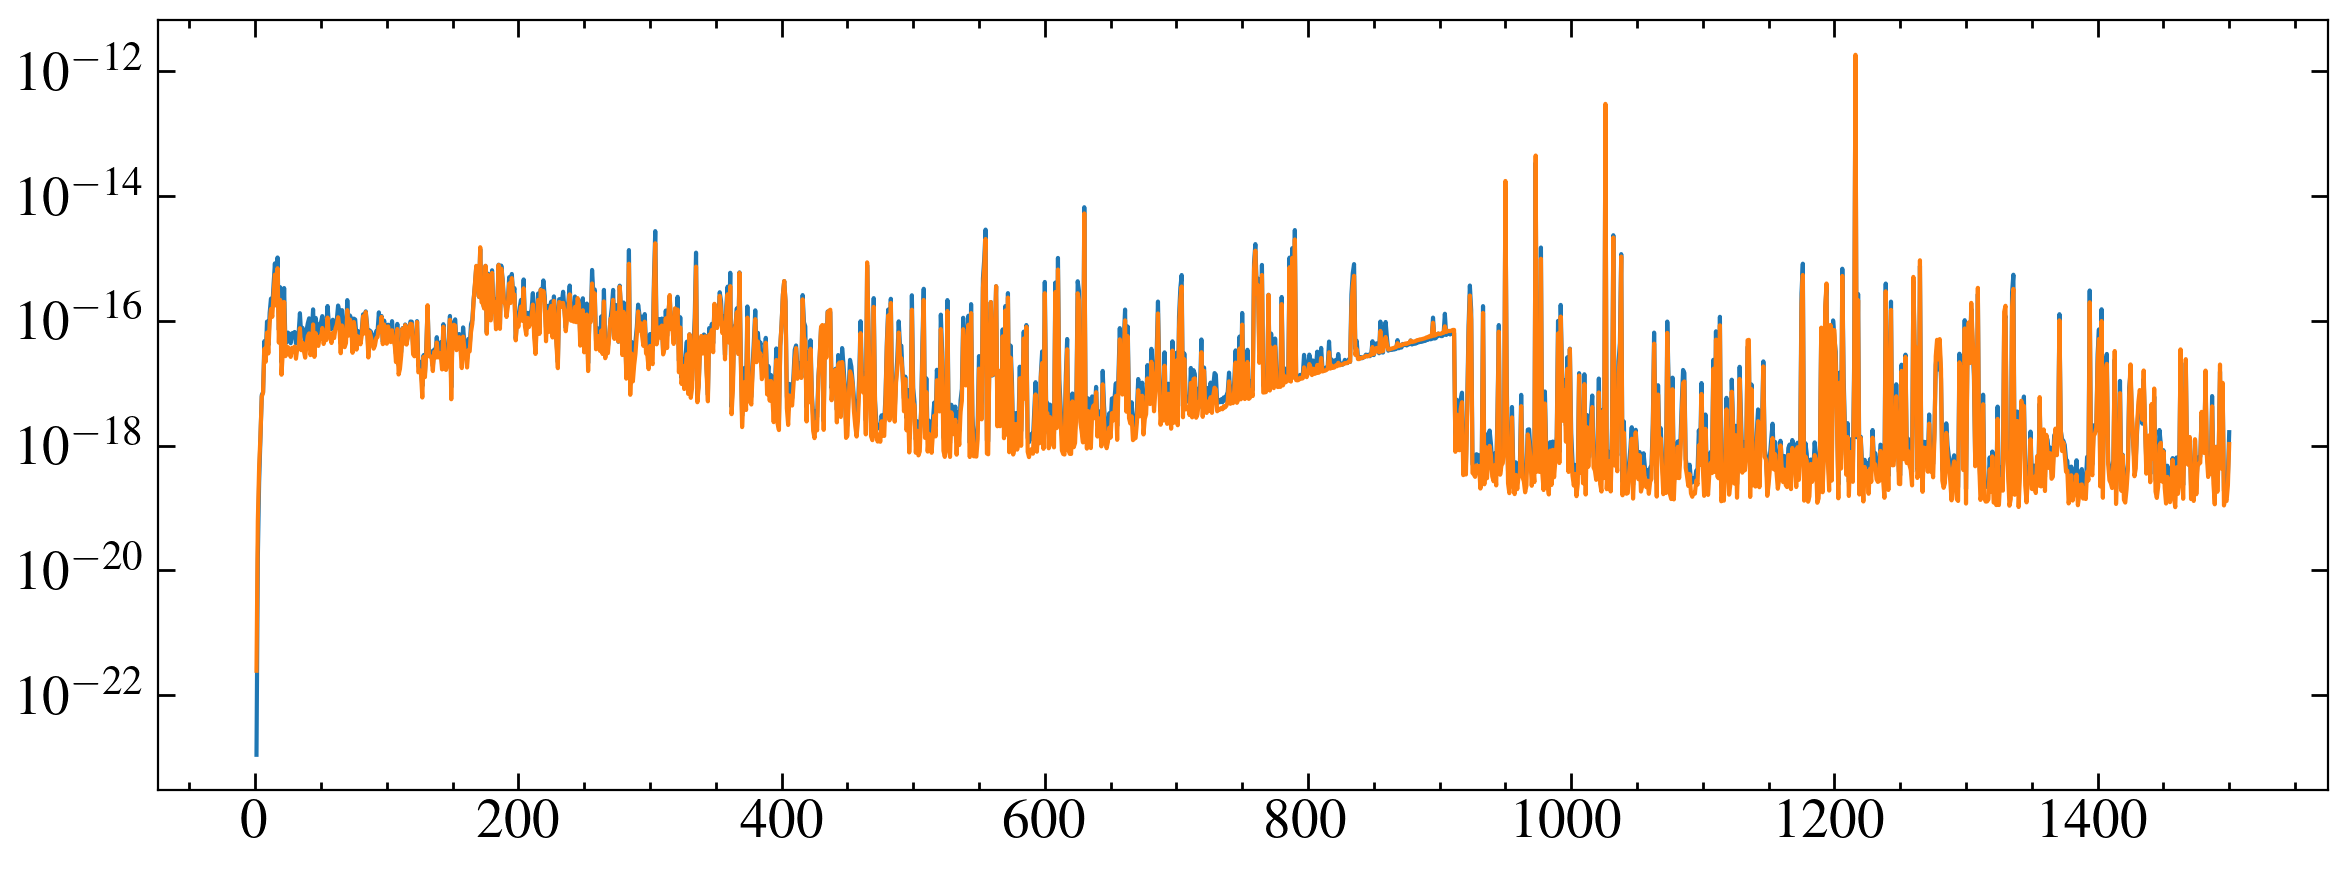

In [19]:
#dem 
dempath = '/media/david/2tb_ext_hd/hddata/meats/dems/toi-260/spectrum_TOI-260_p17.fits'
dem = fits.getdata(dempath, 1)

dw, df= dem['Wavelength'], dem['Flux_density']
eu, el = dem['Upper_Error_84'], dem['Lower_Error_16']


mean_e = np.mean([eu, el], axis=0)
# plt.plot(dw, mean_e)
# plt.yscale('log')

log_mean_e = (eu - el) / (np.log(eu)- np.log(el))

plt.plot(dw, df)
plt.plot(dw, log_mean_e)
# plt.plot(dw, mean_e)

plt.yscale('log')

demtab = Table([dw, df, log_mean_e], names=['WAVELENGTH', 'FLUX', 'ERROR'])
demtab.write('models/toi-260_dem.ecsv', overwrite=True)



In [20]:
prepare_model.make_model_spectrum('models/toi-260_dem.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1, model_name='dem')

Spectrum saved as hlsp_muscles_model_dem_toi-260_na_v1_component-spec.fits


In [21]:
xpath = '/media/david/2tb_ext_hd/hddata/meats/xmm/toi-260/TOI-260.fits'
hdul = fits.open(xpath)
hdr=hdul[0].header
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TARGET  = 'TOI-260 '                                                            
HIERARCH Instrument = 'EPIC    '                                                

In [22]:
hdr.append(('mos1_FILTER', 'Medium'))
hdr.append(('mos2_FILTER', 'Medium'))
hdr.append(('pn_FILTER', 'Medium'))
hdr.append(('pn_DURATION', 18500))
hdr.append(('pn_DATE-OBS', '2023-06-18 18:41:18'))
hdr.append(('pn_DATE-END','2023-06-18 23:49:38' ))
hdr.append(('OBS_ID', '0892000301'))
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TARGET  = 'TOI-260 '                                                            
HIERARCH Instrument = 'EPIC    '                                                
HIERARCH mos1_FILTER = 'Medium  '                                               
HIERARCH mos2_FILTER = 'Medium  '                                               
HIERARCH pn_FILTER = 'Medium  '                                                 
HIERARCH pn_DURATION = 18500                                                    
HIERARCH pn_DATE-OBS = '2023-06-18 18:41:18'                                    
HIERARCH pn_DATE-END = '2023-06-18 23:49:38'                                    
OBS_ID  = '0892000301'      

In [23]:
hdul.writeto('/media/david/2tb_ext_hd/hddata/meats/xmm/toi-260/TOI-260_djw.fits', overwrite=True)


In [24]:
import prepare_xmm

xmm_path = '/media/david/2tb_ext_hd/hddata/meats/xmm/toi-260/TOI-260_djw.fits'

hlsp = dict(Table.read('meats_hlsp_info.csv'))
# hlsp = np.genfromtxt('meats_hlsp_info.csv', delimiter=',', dtype=None, names=True)
# xmm_path = xpath
version = 1

prepare_xmm.make_xmm_spectra(xmm_path, savepath, version, hlsp, apec_repo='models/', make_apec=True, save_ecsv=False, save_fits=True)

Spectrum saved as hlsp_muscles_xmm_epic_toi-260_na_v1_component-spec.fits


Email CS about X-ray params. What proxy? GJ676A

In [47]:
proxpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/v26_hlsp_fixed/GJ676A/hlsp_muscles_hst_stis_gj676a_g140l_v25_component-spec.fits'
# proxpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/v26_hlsp_fixed/GJ676A/hlsp_muscles_hst_cos_gj676a_g130m_v25_component-spec.fits'
proxdata = fits.getdata(proxpath, 1)
proxw, proxf, proxe= proxdata['WAVELENGTH'], proxdata['FLUX'], proxdata['ERROR']


cosspec = fits.getdata('draft_hlsp/toi-260/hlsp_muscles_hst_cos_toi-260_g130m_v1_component-spec.fits', 1)
cw, cf, ce = cosspec['WAVELENGTH'], cosspec['FLUX'], cosspec['ERROR']

1118.8975509303737 1716.264850260954


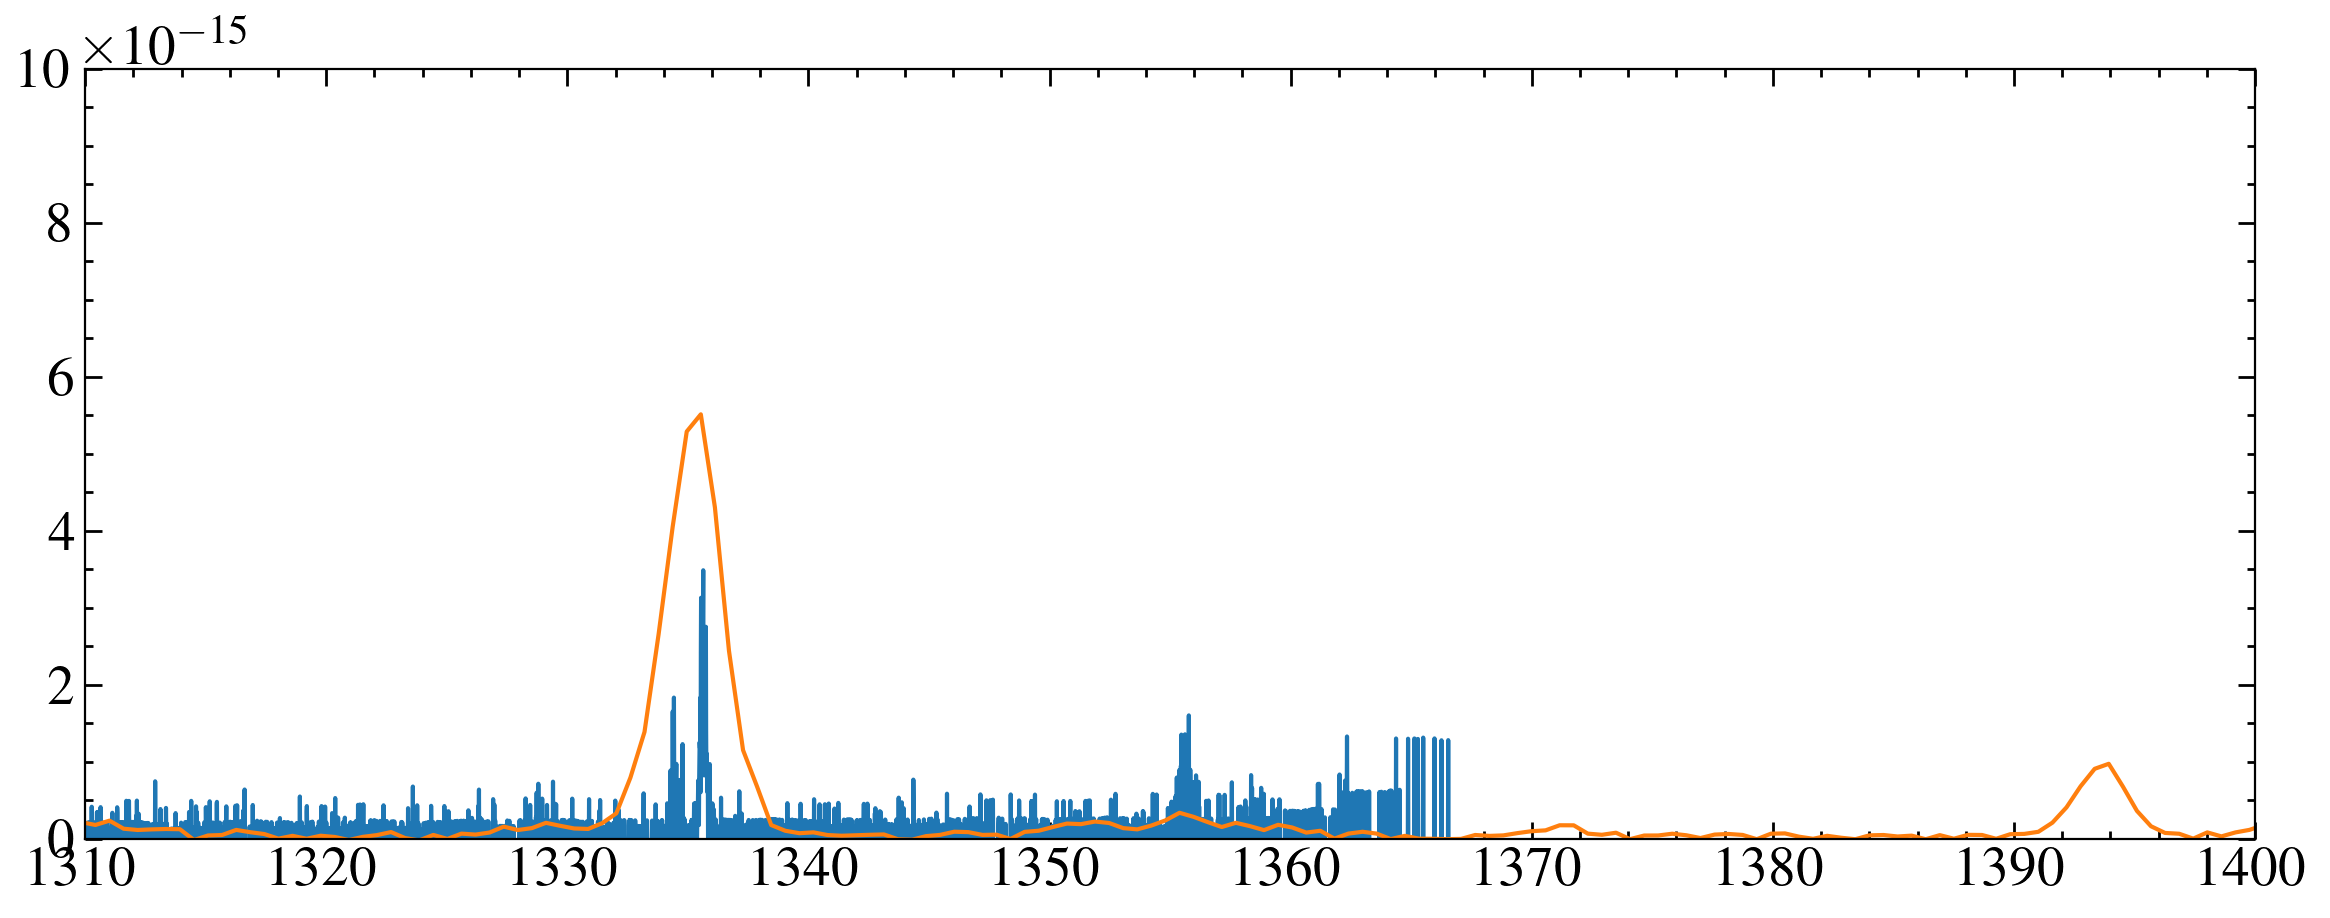

In [48]:
fig, ax = plt.subplots()

dprox = 16
scale = (distance/dprox)**2

ax.plot(cw, cf)
ax.plot(proxw, proxf*scale)

ax.set_xlim(1310, 1400)
# ax.set_xlim(1340, 1360)
ax.set_ylim(0, 1e-14)
print(proxw[0],proxw[-1])

Fair bit brighter - but is a flare! Look at subspectra

/media/david/2tb_ext_hd/hddata/mega_muscles/data/gj676A/stis/odlm04010_x1d.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/data/gj676A/stis/odlm04030_x1d.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/data/gj676A/stis/odlm04040_x1d.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/data/gj676A/stis/odlmz4010_x1d.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/data/gj676A/stis/odlmz4020_x1d.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/data/gj676A/stis/odlmz4030_x1d.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/data/gj676A/stis/odlmz4040_x1d.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/data/gj676A/stis/odlmz4050_x1d.fits


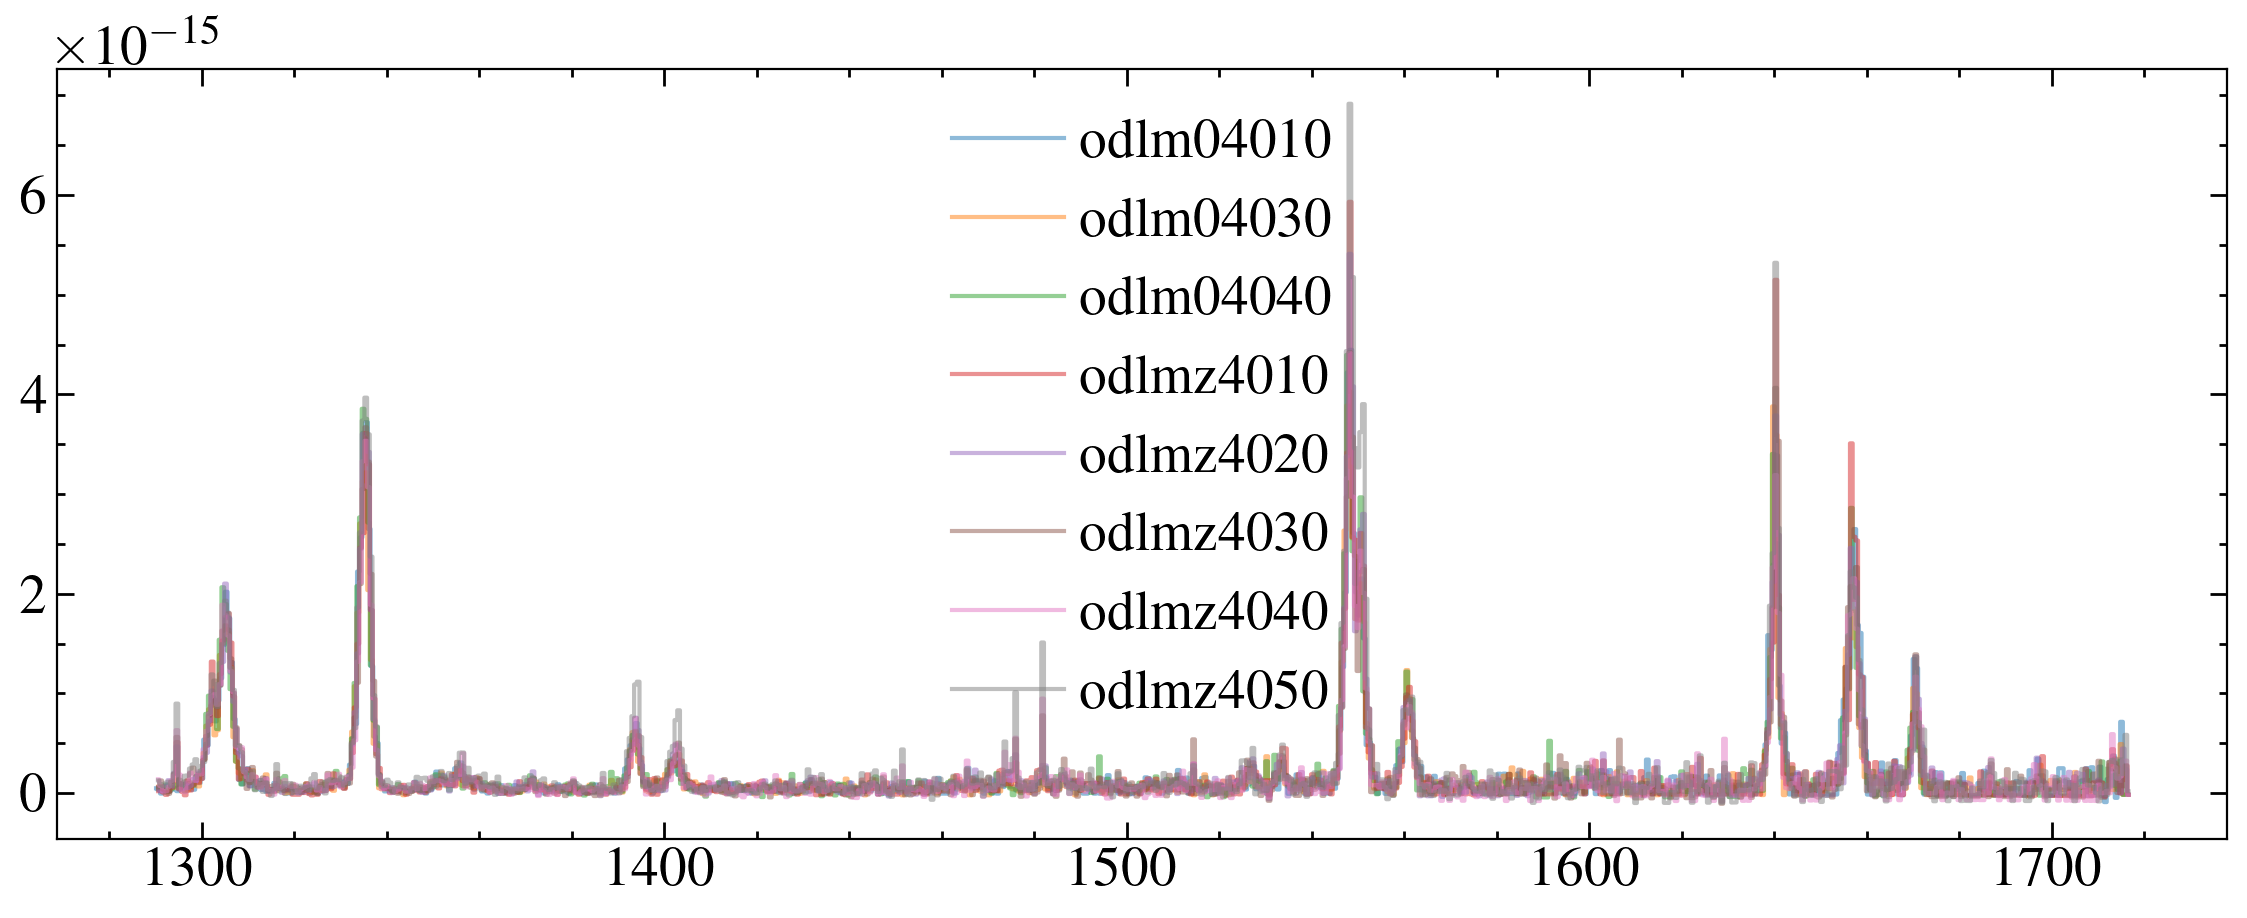

In [37]:
gjpath = '/media/david/2tb_ext_hd/hddata/mega_muscles/data/gj676A/stis/'
gj_x1ds = glob.glob('{}*x1d.fits'.format(gjpath))

fig, ax= plt.subplots()

for x in gj_x1ds:
    if fits.getheader(x, 0)['OPT_ELEM'] == 'G140L': 
        print(x)
        
        data = fits.getdata(x, 1)
        root = fits.getheader(x, 0)['ROOTNAME']
        w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
        mask = w >1290
        w, f, e = w[mask], f[mask], e[mask]
        ax.step(w, f, where='mid', alpha=0.5, label=root)
        # plt.step(w, e, where='mid', c='C1')
ax.legend()

/media/david/2tb_ext_hd/hddata/mega_muscles/data/gj676A/stis/odlm04010_x1d.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/data/gj676A/stis/odlm04030_x1d.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/data/gj676A/stis/odlm04040_x1d.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/data/gj676A/stis/odlmz4010_x1d.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/data/gj676A/stis/odlmz4020_x1d.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/data/gj676A/stis/odlmz4030_x1d.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/data/gj676A/stis/odlmz4040_x1d.fits
/media/david/2tb_ext_hd/hddata/mega_muscles/data/gj676A/stis/odlmz4050_x1d.fits
1118.8975509303737 1716.264850260954


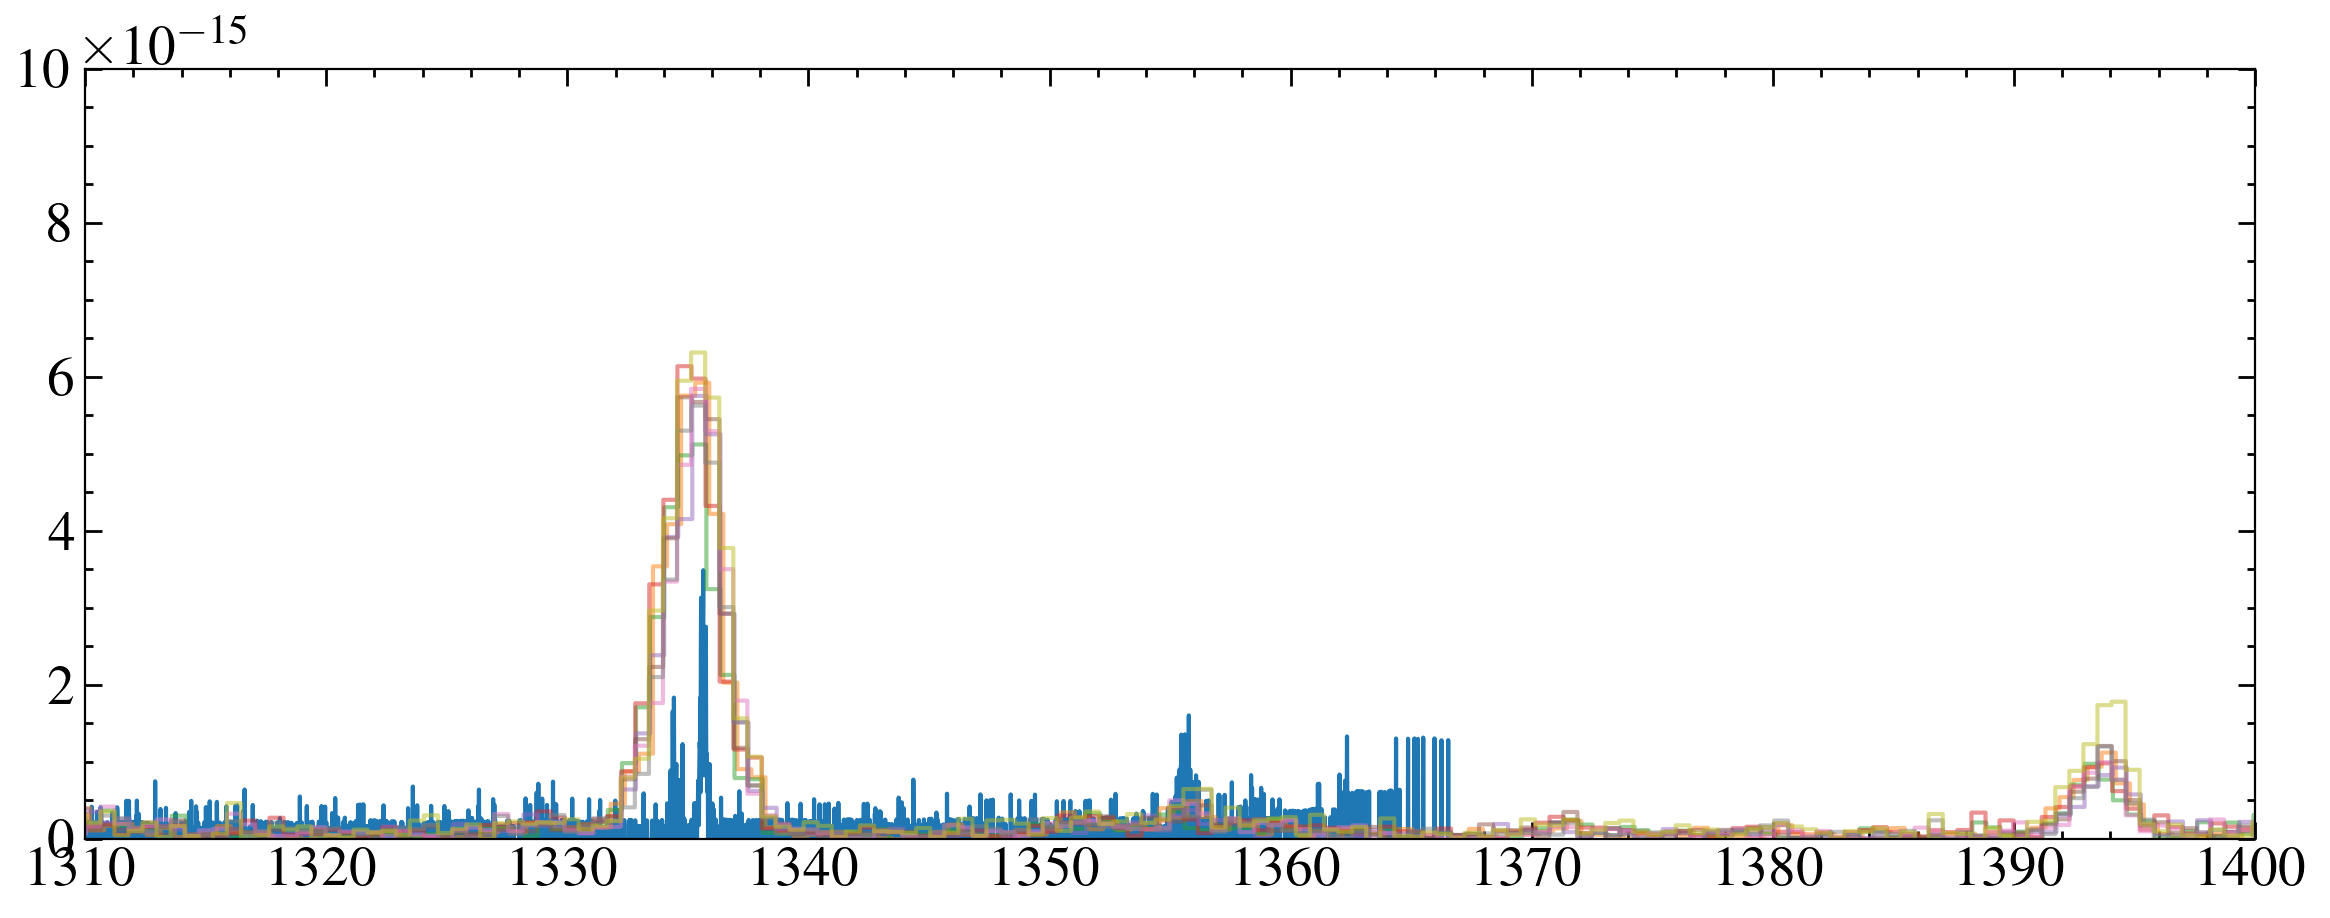

In [49]:
fig, ax = plt.subplots()


dprox = 16
scale = (distance/dprox)**2

ax.plot(cw, cf)
# ax.plot(proxw, proxf*scale)

ax.set_xlim(1310, 1400)
# ax.set_xlim(1340, 1360)
ax.set_ylim(0, 1e-14)


for x in gj_x1ds:
    if fits.getheader(x, 0)['OPT_ELEM'] == 'G140L': 
        print(x)
        
        data = fits.getdata(x, 1)
        root = fits.getheader(x, 0)['ROOTNAME']
        w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
        mask = w >1290
        w, f, e = w[mask], f[mask], e[mask]
        ax.step(w, f*scale, where='mid', alpha=0.5, label=root)

print(proxw[0],proxw[-1])

All too high


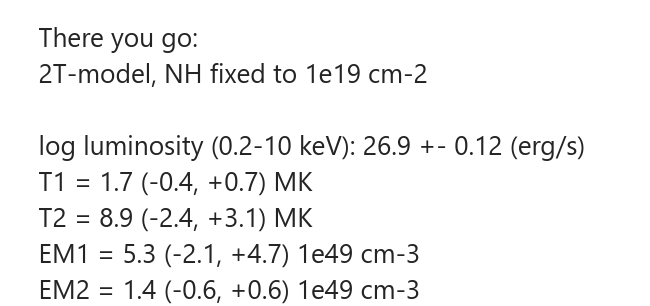
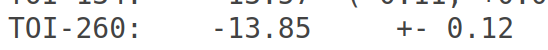

In [27]:
print(10**-13.85)
print(10**(-13.85+0.12)-10**-13.85)
print(10**(-13.85-0.12)-10**-13.85)

1.4125375446227555e-14
4.495495920401102e-15
-3.4101823938514636e-15


In [28]:
for t in (1.7, 0.5, 0.7, 8.9, 2.4, 3.1):

    print(t, (t*1e6*u.K).to(u.keV, equivalencies=u.temperature_energy()))


1.7 0.14649466545646803 keV
0.5 0.04308666631072589 keV
0.7 0.06032133283501625 keV
8.9 0.7669426603309208 keV
2.4 0.20681599829148428 keV
3.1 0.2671373311265005 keV


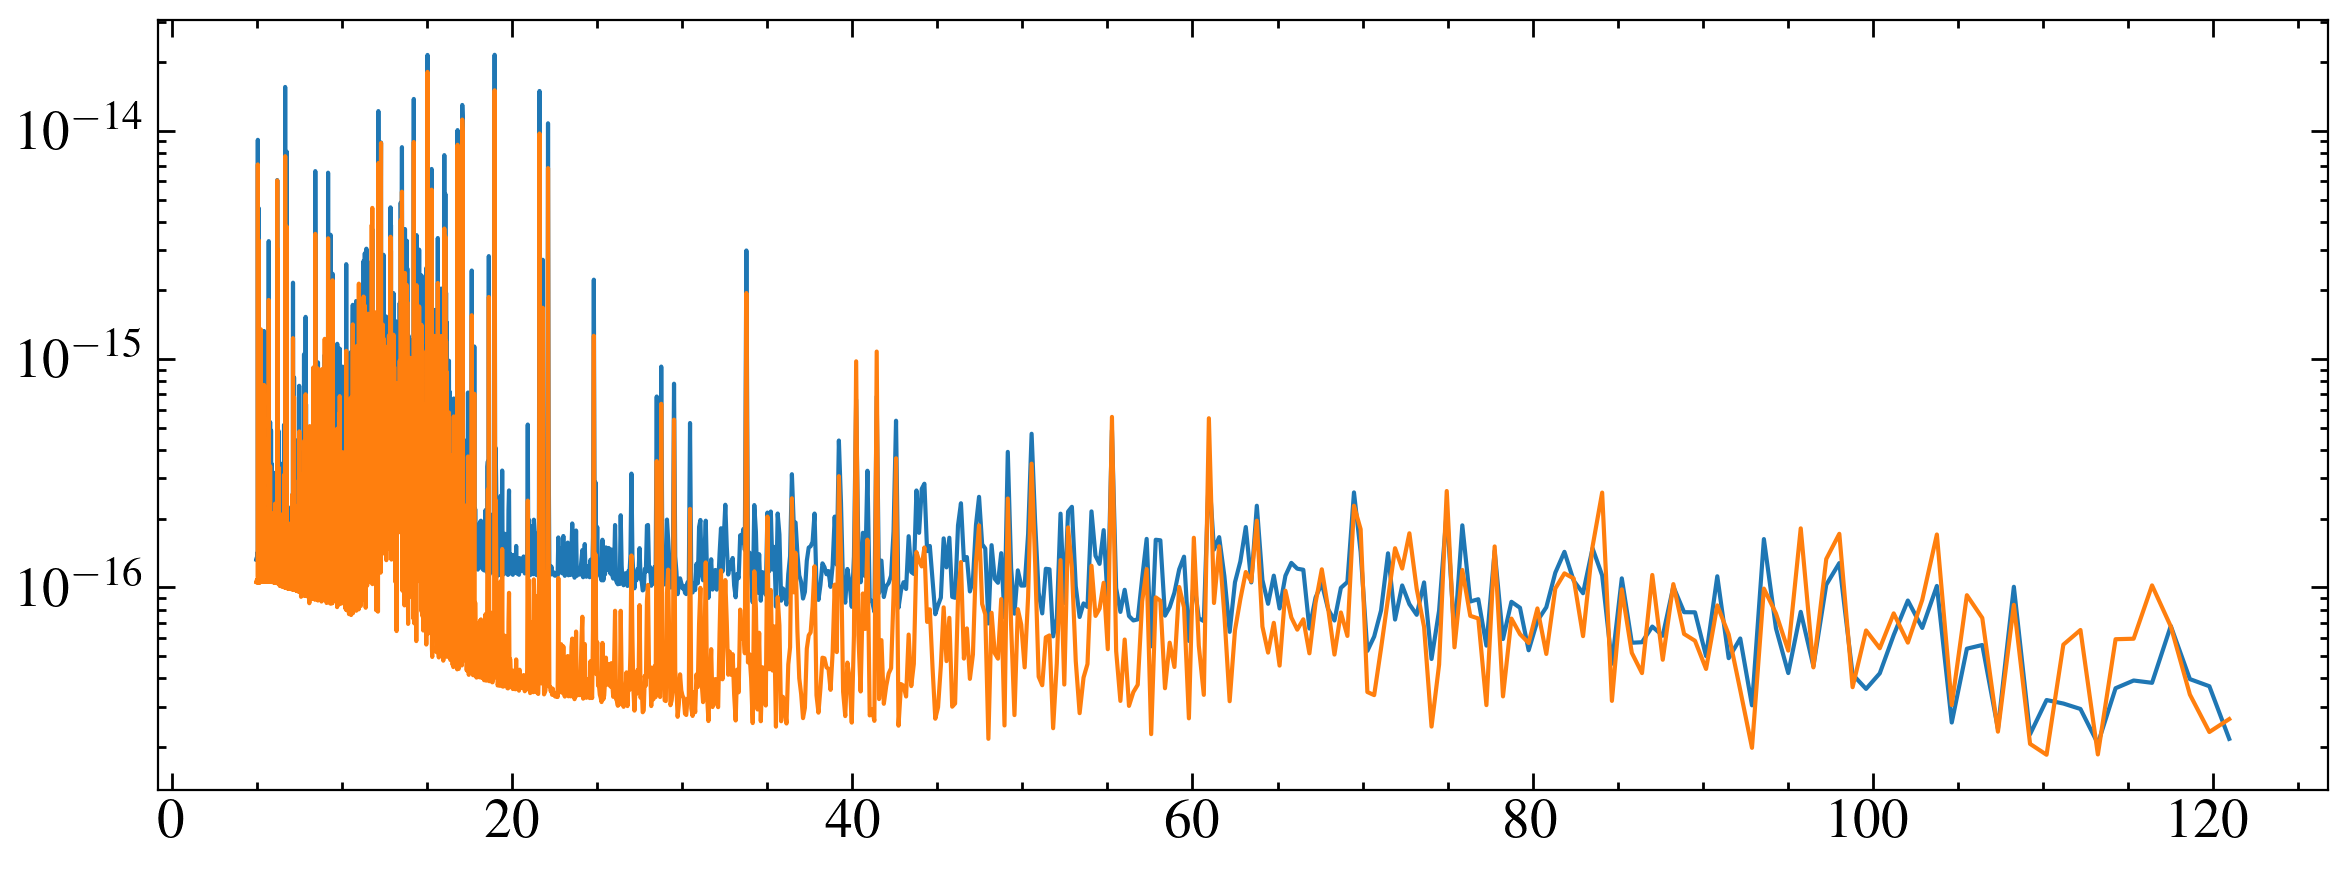

In [29]:
xray = Table.read('models/TOI-260_apec_errs.ecsv')
plt.plot(xray['WAVELENGTH'], xray['FLUX'])
plt.plot(xray['WAVELENGTH'], xray['ERROR'])
# plt.plot(xray['FLUX']/xray['ERROR'])
# xray = Table.read('models/TOI-260_apec_errs_test.ecsv')
# plt.plot(xray['WAVELENGTH'], xray['FLUX'], alpha=0.5)
# plt.plot(xray['WAVELENGTH'], xray['ERROR'], alpha=0.5)


plt.yscale('log')

In [30]:
prepare_model.make_model_spectrum('models/TOI-260_apec_errs.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1.0, model_name='apec')

Spectrum saved as hlsp_muscles_model_apec_toi-260_na_v1_component-spec.fits
